In [2]:
# All Imports

import astra
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import random
import time
import pydicom
import glob
from numba import jit
from skimage import filters
import copy
from scipy import ndimage, misc


import tensorflow as tf
import numpy as np
#import cv2
import sys
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, merge
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import SGD, RMSprop
import random
#from scipy.misc import imresize
import keras.backend as K
import copy


# GAN model

from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, merge
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import ReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np
#from scipy.misc import imsave
import scipy.stats
from skimage.measure import compare_ssim as ssim
import pydicom
from sklearn.cluster import KMeans
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
from skimage import exposure
import glob
#from scipy.misc import imread
from sklearn.metrics import mean_squared_error
from skimage.measure import compare_psnr
import numpy
from numpy.fft import fft2, ifft2, fftshift
import scipy.ndimage.interpolation as ndii

/home/pranjal/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pranjal/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pranjal/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pranjal/anaconda3/envs/te

In [2]:
# [STAR] All the paths for training the model

projectionpath        = '/media/pranjal/cewitdata1/DBT-PROJ-DENOISE/NORMAL/'
highprojectionpath    = '/media/pranjal/cewitdata1/DBT-PROJ-DENOISE/DOUBLE/'
savepath              = '/media/pranjal/newdrive1/DBT-PROJ-DENOISE/'


modelname = "normal-to-three-huber-0.9"

In [4]:
# [STAR] Helper functions for training the de-noising CNN


def bbox2(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def get_crop_image(lowimg, highimg):
    factor = 1
    
    #slice_index = random.randint(0, 24)
    #lowimg  = lowimg[slice_index]
    #highimg = highimg[slice_index]

    thresh  = threshold_otsu(lowimg)
    binary  = lowimg < thresh
    result  = np.multiply(binary, lowimg)

    rmin, rmax, cmin, cmax = bbox2(result)
    resultlowimg = result[rmin:rmax, cmin:cmax]
    resultlowimg = resultlowimg.astype(float)

    result        = np.multiply(binary, highimg)
    resulthighimg = result[rmin:rmax, cmin:cmax]
    resulthighimg = resulthighimg.astype(float)
    
    return resultlowimg, resulthighimg
    
def get_train_data_proj(lowimg, highimg, epoch, batch_size):
    highdose = []
    lowdose  = []
    cliplimit = 0
    
    imgshape = 256
    
    
    # loop till samples of size batch_size with atleast 90% occupancy is not obtained
    crop_count = 0
    
    rowst = lowimg.shape[0]
    colst = lowimg.shape[1]
    
    while(crop_count < batch_size):
        cropimgx = random.randint(1, rowst-imgshape)
        cropimgy = random.randint(1, colst-imgshape)
        
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov = np.sum(lowimg_crop > cliplimit)
        # atleast 90% occupancy should be there
        if nonzerov*1.0/(imgshape*imgshape) < 0.65:
            continue
        
        highimg_crop = highimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        
        #prob = random.randint(0, 100)
        #if prob < 50:
        #    lowimg_crop  = np.fliplr(lowimg_crop)
        #    highimg_crop = np.fliplr(highimg_crop)
        
        #lowimg_crop_mean  = np.mean(lowimg_crop.flatten())
        #highimg_crop_mean = np.mean(highimg_crop.flatten())
        #diff_mean         = highimg_crop_mean -  lowimg_crop_mean
        
        lowdose.append(lowimg_crop)
        highdose.append(highimg_crop)
        
        crop_count = crop_count+1
        
    return np.array(lowdose), np.array(highdose)

def mse(x, y):
    return np.linalg.norm(x - y)

def test_on_whole_proj_200(lowfilename, model):
    highdose = []
    lowdose  = []
    cliplimit = 0
    imgshape  = 200
    
    ds             = pydicom.dcmread(lowfilename)
    limg           = ds.pixel_array
    original_image = copy.deepcopy(limg)
    
    
    cleanimage = np.zeros(limg.shape)
    
    thresh      = threshold_otsu(limg)
    binarymax   = limg > thresh
    
    
    outsideimage_mask = limg > thresh
    insideimage_mask  = limg < thresh
    
    restimage   = binarymax#np.multiply(binarymax, limg)
    minvalue    = np.min(limg)
    
    binary  = limg <= thresh
    limg    = limg - np.min(limg)
    binary1 = limg >= 0
    
    newbinary    = np.multiply(binary, binary1)
    result       = np.multiply(newbinary, limg)
    resultlowimg = result
    resultlowimg = resultlowimg.astype(float)
    resultlowimg = resultlowimg/(thresh/2)
    lowimg       = resultlowimg-1
    
    #print(np.max(lowimg), np.mean(lowimg), np.min(lowimg), thresh)
    
    rowst = limg.shape[0]
    colst = limg.shape[1]
    
    # For top row
    i = 0
    j = 0
    while(j+imgshape < colst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        # If it is not mostly occupied then don't process it
#         if nonzerov*1.0/(imgshape*imgshape) < 0.9:
#             cleanimage[i:i+imgshape, j:j+imgshape] = tempimg
#             j = j+imgshape
#             continue
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = cleanimg[0, :, :, 0]
        j = j+imgshape
    
    
    # For bottom row
    i = rowst-imgshape
    j = 0
    while(j+imgshape < colst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        # If it is not mostly occupied then don't process it
#         if nonzerov*1.0/(imgshape*imgshape) < 0.9:
#             cleanimage[i:i+imgshape, j:j+imgshape] = tempimg
#             j = j+imgshape
#             continue
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = cleanimg[0, :, :, 0]
        j = j+imgshape
    
    # For rightmost column
    j = colst-imgshape
    i = 0
    while(i+imgshape < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        # If it is not mostly occupied then don't process it
#         if nonzerov*1.0/(imgshape*imgshape) < 0.9:
#             cleanimage[i:i+imgshape, j:j+imgshape] = tempimg
#             i = i+imgshape
#             continue    
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = cleanimg[0, :, :, 0]
        i = i+imgshape
    
    # For leftmost column
    j = 0
    i = 0
    while(i+imgshape < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        # If it is not mostly occupied then don't process it
#         if nonzerov*1.0/(imgshape*imgshape) < 0.9:
#             cleanimage[i:i+imgshape, j:j+imgshape] = tempimg
#             i = i+imgshape
#             continue
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = cleanimg[0, :, :, 0]
        i = i+imgshape
    
    halfvalue    = int(imgshape/2)
    quartervalue = int(imgshape/4)#+int(imgshape/2)
    
    # indexes for deciding the patch location
    i = 0 
    j = 0
    while(i+imgshape < rowst):
        # re-initialize the counter for j
        j = 0
        while(j+imgshape < colst):
            cropimgx = i
            cropimgy = j
            
            tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
            
            lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
            nonzerov     = np.sum(lowimg_crop > cliplimit)
            
            # If it is not mostly occupied then don't process it
#             if nonzerov*1.0/(imgshape*imgshape) < 0.5:
#                 cleanimage[i+quartervalue:i+quartervalue+halfvalue, j+quartervalue:j+quartervalue+halfvalue] = tempimg[quartervalue:quartervalue+halfvalue, quartervalue:quartervalue+halfvalue]
#                 j = j+halfvalue
#                 continue
            
            before_mean = np.mean(tempimg)
            cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
            after_mean  = np.mean(cleanimg)
            cleanimg    = cleanimg - (after_mean-before_mean)
            
            #print(np.mean(tempimg), np.mean(cleanimg))
            
            cleanimage[i+quartervalue:i+quartervalue+halfvalue, j+quartervalue:j+quartervalue+halfvalue] = cleanimg[0, :, :, 0][quartervalue:quartervalue+halfvalue, quartervalue:quartervalue+halfvalue]
            j = j+halfvalue
        i = i+halfvalue
    
    #plt.hist(cleanimage.flatten(), bins=256, range=(cliplimit, 1.0), fc='k', ec='k')
    #plt.show()
    
    totalimage  = cleanimage+1
    binarynew   = binary
    
    img_adapteq = np.multiply(totalimage, binarynew)
    #print(np.max(img_adapteq), np.mean(img_adapteq), np.min(img_adapteq), thresh)
    
    mul_result   = img_adapteq*(thresh/2)
    mul_result   = mul_result+minvalue
    
    #print('restimage max  ', np.max(restimage))
    #print('mul_result max ', np.max(mul_result))
    
    tempvalue = np.min(mul_result)
    #restimage = restimage*np.max(mul_result)
    
    #mul_result   = mul_result + restimage
    #mul_result   = mul_result - tempvalue
    
    #print(mul_result.shape, restimage.shape)
    
    
    # Adding the Code to replace the oustide breast region with original values
    mul_result     = mul_result*insideimage_mask        # Get the inside region only
    original_image = original_image*outsideimage_mask   # Get the outside region only
    mul_result     = mul_result+original_image 
    
    #print(np.max(mul_result), np.mean(mul_result), np.min(mul_result))
    #print(np.mean(pt2), np.max(pt2), np.min(pt2))
    mul_result   = mul_result.astype(np.uint16)
    #print(np.mean(mul_result), np.max(mul_result), np.min(mul_result))
    
    ds.PixelData = mul_result.tostring()
    
    savename = lowfilename.split('\\')[-1]
    savepath = cleanprojpath+savename
    ds.save_as(savepath)
    
def test_on_whole_proj(lowfilename, model):
    highdose = []
    lowdose  = []
    cliplimit = 0.
    
    ds     = pydicom.dcmread(lowfilename)
    limg   = ds.pixel_array
    
    cleanimage = np.zeros(limg.shape)
    
    # get the histogram equalized image
    thresh      = threshold_otsu(limg)
    value_range = thresh - np.min(limg)
    binary  = limg <= thresh
    limg    = limg - np.min(limg)
    binary1 = limg >= 0
    newbinary = np.multiply(binary, binary1)
    result    = np.multiply(newbinary, limg)
    resultlowimg = result
    resultlowimg = resultlowimg.astype(float)
    resultlowimg = resultlowimg/thresh
    resultlowimg = exposure.equalize_adapthist(resultlowimg, clip_limit=cliplimit)
    lowimg       = resultlowimg
    
    rowst = limg.shape[0]
    colst = limg.shape[1]
    
    # For top row
    i = 0
    j = 0
    while(j+128 < colst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        lowimg_crop  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        nonzerov     = np.sum(lowimg_crop >= cliplimit)    
        # If it is not mostly occupied then don't process it
        if nonzerov*1.0/(128*128) < 0.9:
            cleanimage[i:i+128, j:j+128] = tempimg
            j = j+128
            continue    
        cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
        cleanimage[i:i+128, j:j+128] = cleanimg[0, :, :, 0]
        j = j+128
    
    
    # For bottom row
    i = rowst-128
    j = 0
    while(j+128 < colst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        lowimg_crop  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        nonzerov     = np.sum(lowimg_crop >= cliplimit)    
        # If it is not mostly occupied then don't process it
        if nonzerov*1.0/(128*128) < 0.9:
            cleanimage[i:i+128, j:j+128] = tempimg
            j = j+128
            continue    
        cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
        cleanimage[i:i+128, j:j+128] = cleanimg[0, :, :, 0]
        j = j+128
    
    # For rightmost column
    j = colst-128
    i = 0
    while(i+128 < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        lowimg_crop  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        nonzerov     = np.sum(lowimg_crop >= cliplimit)    
        # If it is not mostly occupied then don't process it
        if nonzerov*1.0/(128*128) < 0.9:
            cleanimage[i:i+128, j:j+128] = tempimg
            i = i+128
            continue    
        cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
        cleanimage[i:i+128, j:j+128] = cleanimg[0, :, :, 0]
        i = i+128
    
    # For leftmost column
    j = 0
    i = 0
    while(i+128 < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        lowimg_crop  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        nonzerov     = np.sum(lowimg_crop >= cliplimit)    
        # If it is not mostly occupied then don't process it
        if nonzerov*1.0/(128*128) < 0.9:
            cleanimage[i:i+128, j:j+128] = tempimg
            i = i+128
            continue    
        cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
        cleanimage[i:i+128, j:j+128] = cleanimg[0, :, :, 0]
        i = i+128
    
    # indexes for deciding the patch location
    i = 0 
    j = 0
    while(i+128 < rowst):
        # re-initialize the counter for j
        j = 0
        while(j+128 < colst):
            cropimgx = i
            cropimgy = j
                
            tempimg      = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
            
            lowimg_crop  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
            nonzerov     = np.sum(lowimg_crop >= cliplimit)
            
            # If it is not mostly occupied then don't process it
            if nonzerov*1.0/(128*128) < 0.9:
                cleanimage[i+64:i+128, j+64:j+128] = tempimg[32:96, 32:96]
                j = j+64
                continue
            
            cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
            cleanimage[i+64:i+128, j+64:j+128] = cleanimg[0, :, :, 0][32:96, 32:96]
            j = j+64
        i = i+64
    
    #plt.hist(cleanimage.flatten(), bins=256, range=(cliplimit, 1.0), fc='k', ec='k')
    #plt.show()
    
    totalimage  = cleanimage
    binarynew   = binary
    
    img_adapteq = np.multiply(totalimage, binarynew)
    
    print('value range is ', value_range)
    mul_result   = img_adapteq*value_range
    
    print('Max is ', np.max(mul_result))
    print('Min is ', np.min(mul_result))
    
    mul_result   = mul_result.astype(np.uint16)
    
    
    
    print('Max is ', np.max(mul_result))
    print('Min is ', np.min(mul_result))
    
    max_value = np.max(mul_result)
    mul_result[mul_result == 0] = max_value*2
    
    #plt.hist(mul_result.flatten(), bins=256, range=(np.min(mul_result)+0.01, np.max(mul_result)), fc='k', ec='k')
    #plt.show()
    
    ds.PixelData = mul_result.tostring()
    
    savename = lowfilename.split('\\')[-1]
    savepath = cleanprojpath+savename
    ds.save_as(savepath)

def test_on_whole_slice(lowfilename, highfilename, model, xindex, jindex):
    highdose = []
    lowdose  = []
    cliplimit = 0.03
    
    #projindex    = str(slicenum).zfill(2)+'.dcm'
    #lowfilename  = projectionpath+str(filenum)+'_20/_'+projindex
    #highfilename = highprojectionpath+str(filenum)+'_100/_'+projindex
    
    ds     = pydicom.dcmread(lowfilename)
    lowimg = ds.pixel_array
    
    ds      = pydicom.dcmread(highfilename)
    highimg = ds.pixel_array
    
    # get the cropped image
    lowimg, highimg =  get_crop_image(lowimg, highimg, cliplimit)
    
    totalimage      = []
    totalimagereal  = []
    totalimagerealh = []
    
    rowst = lowimg.shape[0]
    colst = lowimg.shape[1]
    
    print('Shape of Image is ', rowst, 'x', colst)
    
    # Change the indexing later to accomodate the full image view
    # Or second option is to do the averaging at the corner views
    
    # count of processed rows in the whole image
    processed_count_total = 0
    
    # indexes for deciding the patch location
    i = 0 
    j = 0
    
    while(i+128 < rowst):
        # for clean image from model
        newrow      = []
        # for the real lowdose image
        newrowreal  = []
        # for the real highdose image
        newrowrealh = []
        # count of images processed in a row
        processed_count_row = 0
        # re-initialize the counter for j
        j = 0
        
        while(j+128 < colst):
            cropimgx = i
            cropimgy = j
                
            tempimg  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
            tempimgh = highimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
            
            newrowreal.append(tempimg[32:96, 32:96])
            newrowrealh.append(tempimgh[32:96, 32:96])
            
#             nonzerov = np.sum(lowimg_crop >= cliplimit)
#             # If it is not mostly occupied then don't process it
#             if nonzerov*1.0/(128*128) < 0.9:
#                 newrow.append(tempimg[32:96, 32:96])
#                 processed_count_row = processed_count_row+1
#                 continue
            
            cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
            newrow.append(cleanimg[0, :, :, 0][32:96, 32:96])
            processed_count_row = processed_count_row+1
            
            if i  == (128*xindex) and j == (128*jindex):
                print('Clean Image SNR',    np.mean(cleanimg[0, :, :, 0])/np.std(cleanimg[0, :, :, 0]))
                print('Original Image SNR', np.mean(tempimg)/np.std(tempimg))
                print('HIGH Original Image SNR', np.mean(tempimgh)/np.std(tempimgh))
                
                ssim_low   = ssim(tempimgh, tempimg, data_range=tempimg.max() - tempimg.min())
                ssim_clean = ssim(tempimgh, cleanimg[0, :, :, 0], data_range=cleanimg[0, :, :, 0].max() - cleanimg[0, :, :, 0].min())
                
                print('SSIM low ',   ssim_low)
                print('SSIM clean ', ssim_clean)
                
                mse_clean   = mse(tempimgh, cleanimg[0, :, :, 0])
                mse_low     = mse(tempimgh, tempimg)
                
                print('MSE low ',   mse_low)
                print('MSE clean ', mse_clean)
                
                imsave('testimage.jpg', tempimg)
                imsave('clean2.jpg', cleanimg[0, :, :, 0])
                imsave('low2.jpg',   tempimg)
                imsave('high2.jpg',  tempimgh)
            j = j+64
        i = i+64
                
        combined = np.array(newrow)
        #print('newrow length is ', len(newrow), combined.shape)
        
        combined = np.hstack(combined.reshape(processed_count_row, 64, 64))
        totalimage.append(combined)
        
        combinedreal = np.array(newrowreal)
        combinedreal = np.hstack(combinedreal.reshape(processed_count_row, 64, 64))
        totalimagereal.append(combinedreal)
        
        combinedrealh = np.array(newrowrealh)
        combinedrealh = np.hstack(combinedrealh.reshape(processed_count_row, 64, 64))
        totalimagerealh.append(combinedrealh)
        
        # increment the rows processed count
        processed_count_total = processed_count_total+1
        
        #print('Shape of the combined image is ', combined.shape)
    
    totalimage = np.array(totalimage)
    totalimage = np.vstack(totalimage.reshape(processed_count_total, 64, processed_count_row*64))
    
    totalimagereal = np.array(totalimagereal)
    totalimagereal = np.vstack(totalimagereal.reshape(processed_count_total, 64, processed_count_row*64))
    
    totalimagerealh = np.array(totalimagerealh)
    totalimagerealh = np.vstack(totalimagerealh.reshape(processed_count_total, 64, processed_count_row*64))
    
    return totalimage, totalimagereal, totalimagerealh

image_indexes_result      = []
temp_image_indexes_result = []

def store_results(epoch, saveseed=5):
    global image_indexes_result
    global temp_image_indexes_result
    
    imgshape = 256
    
    # set the ids for saving the results
    random.seed(saveseed)
    
    projindex    = 55
    lowfilename  = projectionpath+'3200x1600x25.'+str(projindex)+'.raw'
    highfilename = highprojectionpath+'3200x1600x25.'+str(projindex)+'.raw'
    
    lowimg  = np.fromfile(lowfilename, dtype='float32')
    highimg = np.fromfile(highfilename, dtype='float32')
    lowvol  = np.reshape(lowimg, [25, 1600, 3200])/1250.0
    highvol = np.reshape(highimg, [25, 1600, 3200])/3750.0
    
    slice_index = 12#random.randint(0, 24)
    lowimg      = lowvol[slice_index]
    highimg     = highvol[slice_index]
    
    # get the cropped image
    lowimg, highimg =  get_crop_image(lowimg, highimg)
    
    r, c = 6, 6
    x, y = get_train_data_proj(lowimg, highimg, 1, 128)
    x = x-0.5
    y = y-0.5
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95)
    plt.tight_layout()
    fig, axs = plt.subplots(r, c, figsize=(30,10))
    cnt      = 0
    
    for i in range(r):
        for j in range(c):
            if len(image_indexes_result) == 0:
                imgindex = random.randint(1, 127)
                temp_image_indexes_result.append(imgindex)
            else:
                imgindex = image_indexes_result[cnt]
            
            cleanimg = aae.generator.predict(np.expand_dims([x[imgindex]], axis=3))
            combined = np.array([x[imgindex]+0.5, cleanimg[0, :, :, 0]+0.5, y[imgindex]+0.5])
            combined = np.hstack(combined.reshape(3,imgshape,imgshape))
            #print(cleanimg[0, :, :, 0].shape, y[imgindex].shape, combined.shape)
            axs[i,j].imshow(combined, cmap='gray')
            axs[i, j].set_xticklabels([])
            axs[i, j].set_yticklabels([])
            axs[i,j].axis('off')
            cnt += 1
    if len(image_indexes_result) == 0:
        image_indexes_result = temp_image_indexes_result
    plt.subplots_adjust(wspace=0.1, hspace=0)
    fig.savefig(savepath+modelname+"-results/clean_%d.png" % epoch, bbox_inches='tight')
    plt.close()

In [7]:
# [STAR] Model for training the de-noising network

img_shape  = (256, 256, 1)

def huber_loss(y_true, y_pred, clip_delta=0.04):
    error        = y_true - y_pred
    cond         = tf.keras.backend.abs(error) < clip_delta
    squared_loss = 0.5 * tf.keras.backend.square(error)
    linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)
    return tf.where(cond, squared_loss, linear_loss)

def huber_loss_mean(y_true, y_pred, clip_delta=1.0):
    return tf.keras.backend.mean(huber_loss(y_true, y_pred, clip_delta))

class AdversarialAutoencoder():
    def __init__(self):
        self.optimizer1  = RMSprop(0.0005)
        self.optimizer2  = RMSprop(0.00001)
        
        self.clip_value = 0.01
        
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        
        
        #self.discriminator.load_weights('/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/DBT_data/Results/vanilla-gan-weights-mse-0.1/discriminator_weights_8050.h5')
        self.d_arr = []
        self.g_arr = []
        
        # Build the encoder / decoder
        self.generator = self.build_generator()
         
        img = Input(shape=img_shape)
        # The generator takes the image, encodes it and reconstructs it
        # from the encoding
        reconstructed_img            = self.generator(img)
        #self.adversarial_autoencoder = Model(img, reconstructed_img)
        #self.adversarial_autoencoder.compile()
        # For the adversarial_autoencoder model we will only train the generator
        self.discriminator.trainable = False
        
        # The discriminator determines validity of the cleaned image
        validity = self.discriminator(reconstructed_img)

        # The adversarial_autoencoder model  (stacked generator and discriminator)
        self.adversarial_autoencoder = Model(img, [reconstructed_img, validity])
        self.adversarial_autoencoder.compile(loss=[huber_loss_mean, 'mse'],
            loss_weights=[0.9, 0.1],
            optimizer=self.optimizer2)
        
        self.discriminator.trainable = True
        self.discriminator.compile(loss='mse',
            optimizer=self.optimizer1, 
            metrics=['accuracy'])
        #self.discriminator.load_weights('/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/DBT_data/Results/gan-proj-mse-0.99-sub-weights/discriminator_weights_8400.h5')
        #self.generator.load_weights('/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/DBT_data/Results/gan-proj-mse-0.99-sub-weights/generator_weights_8400.h5')

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)
    
    def build_autoencoder(self):
        self.generator.compile(loss=['mse'],optimizer=self.optimizer)
     
    def build_generator(self):
        x = Input(shape=img_shape)
        x1 = Conv2D(32, (3, 3), padding='same')(x)
        x1 = LeakyReLU(alpha=0.2)(x1)
        
        x2 = Conv2D(64, (3, 3), padding='same')(x1)
        #x2 = BatchNormalization(momentum=0.8)(x2)
        x2 = LeakyReLU(alpha=0.2)(x2)
        
        x3 = Conv2D(64, (3, 3), padding='same')(x2)
        #x3 = BatchNormalization(momentum=0.8)(x3)
        x3 = LeakyReLU(alpha=0.2)(x3)
        
        #x3_m = merge([x2, x3], mode='concat', concat_axis=3)
        x4 = Conv2D(64, (3, 3), padding='same')(x3)
        #x4 = BatchNormalization(momentum=0.8)(x4)
        x4 = LeakyReLU(alpha=0.2)(x4)
        #x6_i = merge([x2, x6], mode='concat', concat_axis=3)
        
        
        x5 = Conv2D(128, (3, 3), padding='same')(x4)\
        #x5 = BatchNormalization(momentum=0.8)(x5)
        x5 = LeakyReLU(alpha=0.2)(x5)
        
        #x7_i = merge([x1, x7], mode='concat', concat_axis=3)
        x6 = Conv2D(128, (3, 3), padding='same')(x5)
        x6 = LeakyReLU(alpha=0.2)(x6)
        
        x7 = Conv2D(64, (3, 3), padding='same')(x6)
        #x8 = BatchNormalization(momentum=0.8)(x8)
        x7 = LeakyReLU(alpha=0.2)(x7)
        #x7_m = merge([x1, x6], mode='concat', concat_axis=3)
        #x8    = Conv2D(1, (3, 3), activation='relu', padding='same')(x6)
        x8 = Conv2D(1, (3, 3), padding='same')(x7)
        x8 = LeakyReLU(alpha=0.2)(x8)
        
        out = keras.layers.Subtract()([x, x8])
        #out = ReLU()(out)
        model = Model(x, out)
        return model

    def build_discriminator(self):
        model = Sequential()
        model.add(Conv2D(64, (3, 3), input_shape=img_shape))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Conv2D(64,  (3, 3),  strides=(2, 2)))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Conv2D(64, (3, 3)))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        #         model.add(Conv2D(16, (6, 6),  strides=(2, 2)))
        #         model.add(LeakyReLU(alpha=0.2))
        #         model.add(Dropout(0.5))
        model.add(Conv2D(64, (3, 3),  strides=(2, 2)))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Conv2D(128, (3, 3)))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(128, (3, 3),  strides=(2, 2)))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Dense(1))
        return model
    
    def train_generator_autoencoder(self, epochs, batch_size=128):
        for epoch in range(epochs):
            # Load the dataset
            X_train, Y_train = get_train_data(epoch, batch_size)
            
            X_train = np.expand_dims(X_train, axis=3)
            Y_train = np.expand_dims(Y_train, axis=3)
            
            g_loss = self.generator.train_on_batch(X_train, Y_train)
            
            # Plot the progress
            print ("Epoch ", epoch, " G loss ", g_loss)
            if epoch%50 == 0:
                store_results(epoch)
                self.generator.save_weights(savepath+modelname+'-weights/generator_weights_'+str(epoch)+'.h5')
                self.discriminator.save_weights(savepath+modelname+'-weights/discriminator_weights_'+str(epoch)+'.h5')
    
    def train(self, epochs, batch_size=128, sampling=50, saveseed=5, startepoch=0, discriminator_epochs=5):
        for epoch in range(startepoch, epochs):
            # Train the discriminator 5 times
            #print('Training Discriminator ', epoch)
            
            projindex = str(random.randint(43, 68))#+'.dcm'
    
            lowfilename  = projectionpath+'3200x1600x25.'+str(projindex)+'.raw'
            highfilename = highprojectionpath+'3200x1600x25.'+str(projindex)+'.raw'

            lowimg  = np.fromfile(lowfilename, dtype='float32')
            highimg = np.fromfile(highfilename, dtype='float32')
            
            lowvol  = np.reshape(lowimg,  [25, 1600, 3200])/1250.0
            highvol = np.reshape(highimg, [25, 1600, 3200])/3750.0
            
            for itd in range(discriminator_epochs):
                slice_index = random.randint(0, 24)
                lowimg      = lowvol[slice_index]
                highimg     = highvol[slice_index]
                
                # get the cropped image
                lowimg, highimg =  get_crop_image(lowimg, highimg)
                
                # Load the dataset
                X_train, Y_train = get_train_data_proj(lowimg, highimg, epoch, batch_size)
                X_train = X_train - 0.5
                Y_train = Y_train - 0.5
                
                #print(X_train.shape, Y_train.shape)
                
                X_train = np.expand_dims(X_train, axis=3)
                Y_train = np.expand_dims(Y_train, axis=3)

                # Adversarial ground truths
                valid = np.ones((batch_size, 1))
                fake  = np.zeros((batch_size, 1))

                # ---------------------
                #  Train Discriminator
                # ---------------------
                # get the noisy image and feed it into the generator
                X_train_clean = self.generator.predict(X_train)

                # Train the discriminator (real classified as ones and generated as zeros)
                d_loss_real = self.discriminator.train_on_batch(Y_train, valid)
                d_loss_fake = self.discriminator.train_on_batch(X_train_clean, fake)
                d_loss      = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            #print('Training Generator ', epoch)
            # ---------------------
            #  Train Generator
            # ---------------------
            # Train the generator
            g_loss = self.adversarial_autoencoder.train_on_batch(X_train, [Y_train, valid])
            #print('g_loss ', g_loss)
            self.d_arr.append(d_loss)
            self.g_arr.append(g_loss)
            
            #print('Epoch ', epoch, ' Total D loss ', -d_loss, ' D loss real ', -d_loss_real, ' D loss fake ', d_loss_fake, ' G_loss ', g_loss[0], g_loss[1], g_loss[2])
            # Plot the progress
            #print ("%d [D loss: %f] [G loss: %f] [G loss: %f %f]" % (epoch, 1 - d_loss, 1 - g_loss[0], g_loss[0], g_loss[1]))
            #print('Epoch ', epoch, ' Total D loss ', -d_loss, ' G_loss ', g_loss[0], g_loss[1], g_loss[2])
            
            if epoch%sampling == 0:
                store_results(epoch, saveseed)
                self.generator.save_weights(savepath+modelname+'-weights/generator_weights_'+str(epoch)+'.h5')
                #self.discriminator.save_weights(savepath+modelname+'-weights/discriminator_weights_'+str(epoch)+'.h5')
            
            print ("%d [D loss: %f, mean_acc: %.2f%% real_acc: %.2f%% fake_acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], 100*d_loss_real[1], 100*d_loss_fake[1], g_loss[2]*0.0001, g_loss[1]*0.999))

In [8]:
# [STAR] Training loop of the model

aae = AdversarialAutoencoder()
# print(aae.generator.summary())
# print(aae.discriminator.summary())

(array([1.245759e+06, 6.211870e+05, 1.823630e+05, 3.774400e+04,
        7.845000e+03, 1.802000e+03, 3.750000e+02, 7.300000e+01,
        3.000000e+00, 1.000000e+00]),
 array([0.        , 0.01272   , 0.02544   , 0.03816   , 0.05088   ,
        0.0636    , 0.07632   , 0.08904001, 0.10176001, 0.11448001,
        0.12720001]),
 <a list of 10 Patch objects>)

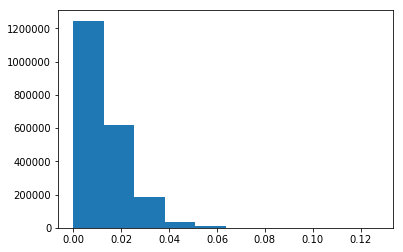

In [19]:
d = np.abs(Y_train -X_train)
plt.hist(d.flatten())

In [23]:
aae.train(epochs=25000, batch_size=32, sampling=50, saveseed=7590, startepoch=0)

/home/pranjal/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.600291, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000098, mse: 0.000131]
1 [D loss: 0.402254, mean_acc: 40.62% real_acc: 0.00% fake_acc: 81.25%] [G loss: 0.000050, mse: 0.000083]
2 [D loss: 0.466878, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000063, mse: 0.000179]
3 [D loss: 0.439424, mean_acc: 10.94% real_acc: 0.00% fake_acc: 21.88%] [G loss: 0.000054, mse: 0.000122]
4 [D loss: 0.461206, mean_acc: 14.06% real_acc: 0.00% fake_acc: 28.12%] [G loss: 0.000093, mse: 0.000169]
5 [D loss: 0.449671, mean_acc: 6.25% real_acc: 0.00% fake_acc: 12.50%] [G loss: 0.000058, mse: 0.000154]
6 [D loss: 0.428354, mean_acc: 14.06% real_acc: 0.00% fake_acc: 28.12%] [G loss: 0.000056, mse: 0.000166]
7 [D loss: 0.397572, mean_acc: 25.00% real_acc: 0.00% fake_acc: 50.00%] [G loss: 0.000054, mse: 0.000193]
8 [D loss: 0.386219, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000072, mse: 0.000213]
9 [D loss: 0.365070, mean_acc: 42.19% real_a

78 [D loss: 0.278648, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000029, mse: 0.000123]
79 [D loss: 0.282995, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000037, mse: 0.000102]
80 [D loss: 0.288049, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000031, mse: 0.000109]
81 [D loss: 0.285480, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000032, mse: 0.000122]
82 [D loss: 0.286991, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000032, mse: 0.000107]
83 [D loss: 0.294995, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000032, mse: 0.000078]
84 [D loss: 0.286755, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000031, mse: 0.000136]
85 [D loss: 0.294872, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000032, mse: 0.000077]
86 [D loss: 0.287012, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000032, mse: 0.000099]
87 [D loss: 0.296227, mean_acc: 0.00% real_acc: 0.00% f

155 [D loss: 0.274219, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000029, mse: 0.000120]
156 [D loss: 0.278320, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000029, mse: 0.000093]
157 [D loss: 0.278967, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000030, mse: 0.000123]
158 [D loss: 0.279205, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000030, mse: 0.000146]
159 [D loss: 0.278093, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000030, mse: 0.000176]
160 [D loss: 0.281611, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000030, mse: 0.000135]
161 [D loss: 0.272244, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000030, mse: 0.000147]
162 [D loss: 0.296514, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000032, mse: 0.000183]
163 [D loss: 0.272744, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000029, mse: 0.000108]
164 [D loss: 0.406064, mean_acc: 0.00% real

232 [D loss: 0.288388, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000033, mse: 0.000102]
233 [D loss: 0.270627, mean_acc: 50.00% real_acc: 100.00% fake_acc: 0.00%] [G loss: 0.000025, mse: 0.000074]
234 [D loss: 0.269772, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000132]
235 [D loss: 0.270393, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000073]
236 [D loss: 0.271019, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000096]
237 [D loss: 0.269188, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000028, mse: 0.000134]
238 [D loss: 0.273242, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000029, mse: 0.000137]
239 [D loss: 0.270978, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000028, mse: 0.000099]
240 [D loss: 0.267299, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000134]
241 [D loss: 0.317049, mean_acc: 0.00% real

309 [D loss: 0.272777, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000029, mse: 0.000167]
310 [D loss: 0.267486, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000029, mse: 0.000126]
311 [D loss: 0.297162, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000031, mse: 0.000139]
312 [D loss: 0.267635, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000028, mse: 0.000175]
313 [D loss: 0.266835, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000028, mse: 0.000101]
314 [D loss: 0.332369, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000032, mse: 0.000096]
315 [D loss: 0.270661, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000029, mse: 0.000104]
316 [D loss: 0.268213, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000029, mse: 0.000078]
317 [D loss: 0.266766, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000028, mse: 0.000166]
318 [D loss: 0.277545, mean_a

386 [D loss: 0.266843, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000029, mse: 0.000096]
387 [D loss: 0.266890, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000029, mse: 0.000134]
388 [D loss: 0.266878, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000028, mse: 0.000137]
389 [D loss: 0.267173, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000028, mse: 0.000100]
390 [D loss: 0.267982, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000029, mse: 0.000134]
391 [D loss: 0.266547, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000029, mse: 0.000099]
392 [D loss: 0.267802, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000030, mse: 0.000107]
393 [D loss: 0.268004, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000028, mse: 0.000122]
394 [D loss: 0.263608, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000028, mse: 0.000135]
395 [D loss: 0.300269, mean_acc

464 [D loss: 0.269925, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000028, mse: 0.000093]
465 [D loss: 0.262977, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000099]
466 [D loss: 0.264707, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000075]
467 [D loss: 0.267211, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000028, mse: 0.000155]
468 [D loss: 0.262992, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000066]
469 [D loss: 0.275050, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000029, mse: 0.000097]
470 [D loss: 0.268102, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000028, mse: 0.000154]
471 [D loss: 0.265690, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000116]
472 [D loss: 0.263578, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000085]
473 [D loss: 0.265998, mean_acc: 0.00% real_ac

542 [D loss: 0.262638, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000097]
543 [D loss: 0.264381, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000111]
544 [D loss: 0.265420, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000123]
545 [D loss: 0.261994, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000090]
546 [D loss: 0.296711, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000035, mse: 0.000114]
547 [D loss: 0.264676, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000028, mse: 0.000088]
548 [D loss: 0.262750, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000103]
549 [D loss: 0.262598, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000113]
550 [D loss: 0.263980, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000028, mse: 0.000096]
551 [D loss: 0.267599, mean_acc: 0.00% real_ac

619 [D loss: 0.263322, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000028, mse: 0.000102]
620 [D loss: 0.263068, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000028, mse: 0.000158]
621 [D loss: 0.263698, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000028, mse: 0.000121]
622 [D loss: 0.263405, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000028, mse: 0.000090]
623 [D loss: 0.261736, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000028, mse: 0.000116]
624 [D loss: 0.313089, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000031, mse: 0.000088]
625 [D loss: 0.263735, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000139]
626 [D loss: 0.262162, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000103]
627 [D loss: 0.262198, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000096]
628 [D loss: 0.263014, me

696 [D loss: 0.261486, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000119]
697 [D loss: 0.263408, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000085]
698 [D loss: 0.261378, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000100]
699 [D loss: 0.265434, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000110]
700 [D loss: 0.262806, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000028, mse: 0.000093]
701 [D loss: 0.263006, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000075]
702 [D loss: 0.263384, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000159]
703 [D loss: 0.263864, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000100]
704 [D loss: 0.264003, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000129]
705 [D loss: 0.263237, mean_acc: 0.00% real

773 [D loss: 14.513202, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000024, mse: 0.000101]
774 [D loss: 0.255039, mean_acc: 50.00% real_acc: 100.00% fake_acc: 0.00%] [G loss: 0.000024, mse: 0.000081]
775 [D loss: 0.255348, mean_acc: 40.62% real_acc: 81.25% fake_acc: 0.00%] [G loss: 0.000025, mse: 0.000123]
776 [D loss: 0.256297, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000025, mse: 0.000093]
777 [D loss: 0.257150, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000083]
778 [D loss: 0.258301, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000102]
779 [D loss: 0.259443, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000082]
780 [D loss: 0.260180, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000089]
781 [D loss: 0.260424, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000100]
782 [D loss: 0.260626, mean_acc: 0.00% r

851 [D loss: 0.259658, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000065]
852 [D loss: 0.262915, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000145]
853 [D loss: 0.259342, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000088]
854 [D loss: 0.258626, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000116]
855 [D loss: 0.261709, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000089]
856 [D loss: 0.262807, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000068]
857 [D loss: 0.259186, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000093]
858 [D loss: 0.258448, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000114]
859 [D loss: 0.259263, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000140]
860 [D loss: 0.261115, mean_acc: 0.00% r

928 [D loss: 0.259525, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000091]
929 [D loss: 0.260276, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000073]
930 [D loss: 0.259302, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000080]
931 [D loss: 0.258154, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000090]
932 [D loss: 0.322102, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000030, mse: 0.000079]
933 [D loss: 0.259719, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000066]
934 [D loss: 0.259173, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000108]
935 [D loss: 0.258747, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000059]
936 [D loss: 0.258421, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000072]
937 [D loss: 0.259451, mean_acc: 50.00% rea

1005 [D loss: 0.259297, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000079]
1006 [D loss: 0.259021, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000060]
1007 [D loss: 0.258469, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000083]
1008 [D loss: 0.262758, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000028, mse: 0.000102]
1009 [D loss: 0.258100, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000126]
1010 [D loss: 0.258475, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000091]
1011 [D loss: 0.260754, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000103]
1012 [D loss: 0.258702, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000130]
1013 [D loss: 0.258338, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000075]
1014 [D loss:

1081 [D loss: 0.257262, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000079]
1082 [D loss: 0.259418, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000071]
1083 [D loss: 0.260168, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000049]
1084 [D loss: 0.257649, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000089]
1085 [D loss: 0.257928, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000048]
1086 [D loss: 0.258863, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000063]
1087 [D loss: 0.259389, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000090]
1088 [D loss: 0.257977, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000092]
1089 [D loss: 0.257963, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000067]
1090 [D loss: 0.260355, mean_acc: 

1157 [D loss: 0.258801, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000073]
1158 [D loss: 0.258418, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000091]
1159 [D loss: 0.258209, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000112]
1160 [D loss: 0.257607, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000079]
1161 [D loss: 0.258538, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000091]
1162 [D loss: 0.257732, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000115]
1163 [D loss: 0.259123, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000067]
1164 [D loss: 0.258161, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000062]
1165 [D loss: 0.257569, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000066]
1166 [D loss: 0.259209, mean_acc: 0.0

1233 [D loss: 0.257726, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000044]
1234 [D loss: 0.258155, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000079]
1235 [D loss: 0.258179, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000045]
1236 [D loss: 0.257886, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000056]
1237 [D loss: 0.261102, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000079]
1238 [D loss: 0.258886, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000082]
1239 [D loss: 0.257749, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000059]
1240 [D loss: 0.257909, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000081]
1241 [D loss: 0.258018, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000058]
1242 [D loss: 0.257928, mean_ac

1309 [D loss: 0.257688, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000100]
1310 [D loss: 0.258543, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000071]
1311 [D loss: 0.257425, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000082]
1312 [D loss: 0.257648, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000103]
1313 [D loss: 0.257969, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000061]
1314 [D loss: 0.257155, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000056]
1315 [D loss: 0.258451, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000059]
1316 [D loss: 0.258315, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000041]
1317 [D loss: 0.256782, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000094]
1318 [D lo

1385 [D loss: 0.258816, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000041]
1386 [D loss: 0.256907, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000052]
1387 [D loss: 0.258139, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000073]
1388 [D loss: 0.257683, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000074]
1389 [D loss: 0.256908, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000054]
1390 [D loss: 0.259164, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000074]
1391 [D loss: 0.258662, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000053]
1392 [D loss: 0.256652, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000057]
1393 [D loss: 0.257839, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000068]
1394 [D loss: 0.257067

1461 [D loss: 0.256630, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000078]
1462 [D loss: 0.259937, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000097]
1463 [D loss: 0.256493, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000058]
1464 [D loss: 0.257320, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000052]
1465 [D loss: 0.258139, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000054]
1466 [D loss: 0.258461, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000039]
1467 [D loss: 0.256986, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000090]
1468 [D loss: 0.256672, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000039]
1469 [D loss: 0.257054, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000055]
1470 [D loss: 0.256528, mean_ac

1537 [D loss: 0.257466, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000069]
1538 [D loss: 0.256809, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000071]
1539 [D loss: 0.257924, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000052]
1540 [D loss: 0.257533, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000070]
1541 [D loss: 0.256187, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000051]
1542 [D loss: 0.261732, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000054]
1543 [D loss: 0.257235, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000065]
1544 [D loss: 0.256184, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000072]
1545 [D loss: 0.257314, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000051]
1546 [D loss: 0.256445, mean_acc: 0.0

1613 [D loss: 0.257000, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000055]
1614 [D loss: 0.256159, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000050]
1615 [D loss: 0.259271, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000052]
1616 [D loss: 0.255951, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000037]
1617 [D loss: 0.257194, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000083]
1618 [D loss: 0.257194, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000036]
1619 [D loss: 0.255876, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000053]
1620 [D loss: 0.262683, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000084]
1621 [D loss: 0.256645, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000062]
1622 [D loss: 0.256091, mean_acc: 0.0

1690 [D loss: 0.256695, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000067]
1691 [D loss: 0.260383, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000049]
1692 [D loss: 0.256626, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000052]
1693 [D loss: 0.256688, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000061]
1694 [D loss: 0.256481, mean_acc: 40.62% real_acc: 0.00% fake_acc: 81.25%] [G loss: 0.000026, mse: 0.000069]
1695 [D loss: 0.255832, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000048]
1696 [D loss: 0.257378, mean_acc: 45.31% real_acc: 0.00% fake_acc: 90.62%] [G loss: 0.000026, mse: 0.000062]
1697 [D loss: 0.256283, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000044]
1698 [D loss: 0.257905, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000052]
1699 [D loss: 0.255774, mean

1766 [D loss: 0.256575, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000036]
1767 [D loss: 0.255934, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000080]
1768 [D loss: 0.264021, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000029, mse: 0.000035]
1769 [D loss: 0.257009, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000053]
1770 [D loss: 0.256083, mean_acc: 28.12% real_acc: 0.00% fake_acc: 56.25%] [G loss: 0.000026, mse: 0.000081]
1771 [D loss: 0.255836, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000060]
1772 [D loss: 0.257516, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000043]
1773 [D loss: 0.256499, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000056]
1774 [D loss: 0.256075, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000043]
1775 [D loss: 0.259307, mean_acc:

1842 [D loss: 0.256690, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000050]
1843 [D loss: 0.305882, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000060]
1844 [D loss: 0.256776, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000067]
1845 [D loss: 0.256474, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000047]
1846 [D loss: 0.256136, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000060]
1847 [D loss: 0.256969, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000028, mse: 0.000042]
1848 [D loss: 0.256061, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000050]
1849 [D loss: 0.255606, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000058]
1850 [D loss: 0.260005, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000048]
1851 [D loss: 0.255756, mean_

1918 [D loss: 0.255690, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000034]
1919 [D loss: 0.255999, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000050]
1920 [D loss: 0.256312, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000079]
1921 [D loss: 0.255992, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000058]
1922 [D loss: 0.255970, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000042]
1923 [D loss: 0.256727, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000055]
1924 [D loss: 0.256405, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000043]
1925 [D loss: 0.255221, mean_acc: 40.62% real_acc: 0.00% fake_acc: 81.25%] [G loss: 0.000026, mse: 0.000068]
1926 [D loss: 0.260113, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000050]
1927 [D loss: 0.256539, mean_

1994 [D loss: 0.255308, mean_acc: 37.50% real_acc: 0.00% fake_acc: 75.00%] [G loss: 0.000026, mse: 0.000065]
1995 [D loss: 0.258131, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000046]
1996 [D loss: 0.255714, mean_acc: 42.19% real_acc: 0.00% fake_acc: 84.38%] [G loss: 0.000026, mse: 0.000059]
1997 [D loss: 0.256591, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000042]
1998 [D loss: 0.258850, mean_acc: 43.75% real_acc: 0.00% fake_acc: 87.50%] [G loss: 0.000027, mse: 0.000050]
1999 [D loss: 0.255869, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000057]
2000 [D loss: 0.255804, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000046]
2001 [D loss: 0.256311, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000036]
2002 [D loss: 0.256300, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000086]
2003 [D loss: 0.257177, mean

2070 [D loss: 0.255417, mean_acc: 37.50% real_acc: 0.00% fake_acc: 75.00%] [G loss: 0.000026, mse: 0.000076]
2071 [D loss: 0.257539, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000057]
2072 [D loss: 0.255621, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000041]
2073 [D loss: 0.255212, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000053]
2074 [D loss: 0.258911, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000042]
2075 [D loss: 0.255550, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000066]
2076 [D loss: 0.255587, mean_acc: 45.31% real_acc: 0.00% fake_acc: 90.62%] [G loss: 0.000026, mse: 0.000049]
2077 [D loss: 0.256329, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000044]
2078 [D loss: 0.255400, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000053]
2079 [D loss: 0.259782, mean_

2146 [D loss: 0.255822, mean_acc: 45.31% real_acc: 0.00% fake_acc: 90.62%] [G loss: 0.000026, mse: 0.000057]
2147 [D loss: 0.260745, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000040]
2148 [D loss: 0.256388, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000048]
2149 [D loss: 0.256030, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000055]
2150 [D loss: 0.256130, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000045]
2151 [D loss: 0.257636, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000035]
2152 [D loss: 0.255273, mean_acc: 45.31% real_acc: 0.00% fake_acc: 90.62%] [G loss: 0.000026, mse: 0.000083]
2153 [D loss: 0.259745, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000050]
2154 [D loss: 0.255544, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000065]
2155 [D loss: 0.

2222 [D loss: 0.256168, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000040]
2223 [D loss: 0.256106, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000052]
2224 [D loss: 0.256006, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000040]
2225 [D loss: 0.258386, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000064]
2226 [D loss: 0.255339, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000047]
2227 [D loss: 0.255636, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000043]
2228 [D loss: 0.255508, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000052]
2229 [D loss: 0.257137, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000043]
2230 [D loss: 0.255266, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000046]
2231 [D loss:

2298 [D loss: 0.254967, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000047]
2299 [D loss: 0.259615, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000054]
2300 [D loss: 0.255768, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000044]
2301 [D loss: 0.255111, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000035]
2302 [D loss: 0.255468, mean_acc: 40.62% real_acc: 0.00% fake_acc: 81.25%] [G loss: 0.000026, mse: 0.000081]
2303 [D loss: 0.255266, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000049]
2304 [D loss: 0.256750, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000063]
2305 [D loss: 0.254961, mean_acc: 45.31% real_acc: 0.00% fake_acc: 90.62%] [G loss: 0.000026, mse: 0.000049]
2306 [D loss: 0.259671, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000030, mse: 0.000038]
2307 [D loss: 0.256432, m

2374 [D loss: 0.257516, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000040]
2375 [D loss: 0.255022, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000063]
2376 [D loss: 0.256032, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000047]
2377 [D loss: 0.255643, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000042]
2378 [D loss: 0.254903, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000051]
2379 [D loss: 0.290430, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000042]
2380 [D loss: 0.255422, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000045]
2381 [D loss: 0.255593, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000051]
2382 [D loss: 0.255727, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000046]
2383 [D loss: 0.255794, mean

2450 [D loss: 0.255723, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000043]
2451 [D loss: 0.256398, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000034]
2452 [D loss: 0.255201, mean_acc: 42.19% real_acc: 0.00% fake_acc: 84.38%] [G loss: 0.000026, mse: 0.000079]
2453 [D loss: 0.256082, mean_acc: 45.31% real_acc: 0.00% fake_acc: 90.62%] [G loss: 0.000027, mse: 0.000048]
2454 [D loss: 0.255230, mean_acc: 45.31% real_acc: 0.00% fake_acc: 90.62%] [G loss: 0.000026, mse: 0.000062]
2455 [D loss: 0.254814, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000047]
2456 [D loss: 0.262598, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.001159, mse: 0.000037]
2457 [D loss: 0.253981, mean_acc: 50.00% real_acc: 100.00% fake_acc: 0.00%] [G loss: 0.000025, mse: 0.000061]
2458 [D loss: 0.254078, mean_acc: 50.00% real_acc: 100.00% fake_acc: 0.00%] [G loss: 0.000025, mse: 0.000071]
2459 [D loss: 0.2547

2526 [D loss: 0.254861, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000047]
2527 [D loss: 0.255475, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000043]
2528 [D loss: 0.256715, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000051]
2529 [D loss: 0.255716, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000043]
2530 [D loss: 0.254977, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000046]
2531 [D loss: 0.255800, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000051]
2532 [D loss: 0.256005, mean_acc: 35.94% real_acc: 0.00% fake_acc: 71.88%] [G loss: 0.000026, mse: 0.000046]
2533 [D loss: 0.255680, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000034]
2534 [D loss: 0.256660, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000056]
2535 [D loss: 0.255526,

2602 [D loss: 0.255593, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000078]
2603 [D loss: 0.255705, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000047]
2604 [D loss: 0.254992, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000061]
2605 [D loss: 0.257319, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000047]
2606 [D loss: 0.254906, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000036]
2607 [D loss: 0.254962, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000050]
2608 [D loss: 0.257202, mean_acc: 37.50% real_acc: 0.00% fake_acc: 75.00%] [G loss: 0.000026, mse: 0.000060]
2609 [D loss: 0.254777, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000074]
2610 [D loss: 0.257567, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000032, mse: 0.000054]
2611 [D loss: 0.25

2678 [D loss: 0.254643, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000050]
2679 [D loss: 0.257039, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000041]
2680 [D loss: 0.254853, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000044]
2681 [D loss: 0.255170, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000050]
2682 [D loss: 0.256753, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000045]
2683 [D loss: 0.255585, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000032]
2684 [D loss: 0.255200, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000055]
2685 [D loss: 0.255758, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000031]
2686 [D loss: 0.254878, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000040]
2687 [D loss: 0.256195, 

2754 [D loss: 0.255748, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000060]
2755 [D loss: 0.254735, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000046]
2756 [D loss: 0.274202, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000036]
2757 [D loss: 0.255446, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000048]
2758 [D loss: 0.255350, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000059]
2759 [D loss: 0.255316, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000072]
2760 [D loss: 0.255286, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000053]
2761 [D loss: 0.254915, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000060]
2762 [D loss: 0.255617, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000075]
2763 [D loss: 0

2830 [D loss: 0.254542, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000043]
2831 [D loss: 0.255008, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000049]
2832 [D loss: 0.255614, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000044]
2833 [D loss: 0.255252, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000031]
2834 [D loss: 0.254773, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000054]
2835 [D loss: 0.259239, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000030]
2836 [D loss: 0.255539, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000040]
2837 [D loss: 0.254834, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000055]
2838 [D loss: 0.255553, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000056]
2839 [D loss: 0.254924,

2906 [D loss: 0.254922, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000038]
2907 [D loss: 0.254762, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000048]
2908 [D loss: 0.254659, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000058]
2909 [D loss: 0.256226, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000071]
2910 [D loss: 0.254497, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000052]
2911 [D loss: 0.254588, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000059]
2912 [D loss: 0.256707, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000073]
2913 [D loss: 0.254588, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000044]
2914 [D loss: 0.254791, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000041]
2915 [D loss: 0.7

2981 [D loss: 0.254384, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000047]
2982 [D loss: 0.255810, mean_acc: 39.06% real_acc: 0.00% fake_acc: 78.12%] [G loss: 0.000026, mse: 0.000043]
2983 [D loss: 0.254649, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000030]
2984 [D loss: 0.255204, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000053]
2985 [D loss: 0.256141, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000030]
2986 [D loss: 0.254528, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000039]
2987 [D loss: 0.254452, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000055]
2988 [D loss: 0.254701, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000055]
2989 [D loss: 0.255535, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000041]
2990 [D loss: 0.

3057 [D loss: 0.254232, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000046]
3058 [D loss: 0.255021, mean_acc: 45.31% real_acc: 0.00% fake_acc: 90.62%] [G loss: 0.000026, mse: 0.000056]
3059 [D loss: 0.254950, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000069]
3060 [D loss: 0.254373, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000051]
3061 [D loss: 0.265437, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000058]
3062 [D loss: 0.255267, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000072]
3063 [D loss: 0.254797, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000043]
3064 [D loss: 0.255908, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000040]
3065 [D loss: 0.254391, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000041]
3066 [D loss: 0.256352

3133 [D loss: 0.254348, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000029]
3134 [D loss: 0.256394, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000051]
3135 [D loss: 0.254182, mean_acc: 45.31% real_acc: 0.00% fake_acc: 90.62%] [G loss: 0.000026, mse: 0.000029]
3136 [D loss: 0.255369, mean_acc: 1.56% real_acc: 0.00% fake_acc: 3.12%] [G loss: 0.000026, mse: 0.000038]
3137 [D loss: 0.256864, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000053]
3138 [D loss: 0.254807, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000054]
3139 [D loss: 0.254596, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000040]
3140 [D loss: 0.254316, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000053]
3141 [D loss: 0.256720, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000039]
3142 [D loss: 0.254446,

3209 [D loss: 0.254555, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000067]
3210 [D loss: 0.256796, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000050]
3211 [D loss: 0.254348, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000056]
3212 [D loss: 0.254533, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000070]
3213 [D loss: 0.257491, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000042]
3214 [D loss: 0.254541, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000039]
3215 [D loss: 0.254292, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000041]
3216 [D loss: 0.254979, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000030]
3217 [D loss: 0.254312, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000065]
3218 [D loss: 0.26

3285 [D loss: 0.254648, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000028]
3286 [D loss: 0.256908, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000037]
3287 [D loss: 0.254057, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000052]
3288 [D loss: 0.256681, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000053]
3289 [D loss: 0.254213, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000039]
3290 [D loss: 0.254050, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000052]
3291 [D loss: 0.258710, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000039]
3292 [D loss: 0.254144, mean_acc: 1.56% real_acc: 0.00% fake_acc: 3.12%] [G loss: 0.000026, mse: 0.000041]
3293 [D loss: 0.254023, mean_acc: 42.19% real_acc: 0.00% fake_acc: 84.38%] [G loss: 0.000026, mse: 0.000048]
3294 [D loss: 0.254905, mean_acc: 3

3361 [D loss: 0.255401, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000055]
3362 [D loss: 0.254328, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000068]
3363 [D loss: 0.254438, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000041]
3364 [D loss: 0.255646, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000038]
3365 [D loss: 0.253950, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000039]
3366 [D loss: 0.255548, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000029]
3367 [D loss: 0.254962, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000063]
3368 [D loss: 0.254272, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000027]
3369 [D loss: 0.254198, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000040]
3370 [D loss:

3437 [D loss: 0.254126, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000050]
3438 [D loss: 0.254231, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000051]
3439 [D loss: 0.256875, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000038]
3440 [D loss: 0.254101, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000051]
3441 [D loss: 0.253928, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000038]
3442 [D loss: 0.254283, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000041]
3443 [D loss: 0.254050, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000048]
3444 [D loss: 0.255390, mean_acc: 39.06% real_acc: 0.00% fake_acc: 78.12%] [G loss: 0.000026, mse: 0.000053]
3445 [D loss: 0.254368, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000038]
3446 [D loss: 0.2

3513 [D loss: 0.254258, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000040]
3514 [D loss: 0.254291, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000037]
3515 [D loss: 0.254367, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000038]
3516 [D loss: 0.254473, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000028]
3517 [D loss: 0.254674, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000062]
3518 [D loss: 0.254292, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000027]
3519 [D loss: 0.254256, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000039]
3520 [D loss: 0.254046, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000062]
3521 [D loss: 0.253876, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000046]
3522 [D loss: 0.261614, mean_acc: 0.0

3589 [D loss: 0.253646, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000041]
3590 [D loss: 0.253864, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000053]
3591 [D loss: 0.255639, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000040]
3592 [D loss: 0.254072, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000042]
3593 [D loss: 0.253660, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000048]
3594 [D loss: 0.256509, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000053]
3595 [D loss: 0.254623, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000039]
3596 [D loss: 0.253934, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000048]
3597 [D loss: 0.253949, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000035]
3598 [D loss: 0.254

3665 [D loss: 0.253787, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000038]
3666 [D loss: 0.254193, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000028]
3667 [D loss: 0.253637, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000061]
3668 [D loss: 0.254686, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000027]
3669 [D loss: 0.253507, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000039]
3670 [D loss: 0.260389, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000062]
3671 [D loss: 0.254164, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000046]
3672 [D loss: 0.253981, mean_acc: 1.56% real_acc: 0.00% fake_acc: 3.12%] [G loss: 0.000026, mse: 0.000034]
3673 [D loss: 0.253861, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000043]
3674 [D loss: 0.254465, mean_acc

3741 [D loss: 0.254600, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000037]
3742 [D loss: 0.253963, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000039]
3743 [D loss: 0.253625, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000045]
3744 [D loss: 0.262671, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000051]
3745 [D loss: 0.253964, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000037]
3746 [D loss: 0.253819, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000046]
3747 [D loss: 0.253897, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000033]
3748 [D loss: 0.253737, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000039]
3749 [D loss: 0.254444, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000045]
3750 [D loss: 0.

3817 [D loss: 0.253659, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000060]
3818 [D loss: 0.255186, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000026]
3819 [D loss: 0.254356, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000038]
3820 [D loss: 0.253749, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000060]
3821 [D loss: 0.253576, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000045]
3822 [D loss: 0.253936, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000033]
3823 [D loss: 0.253713, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000043]
3824 [D loss: 0.255945, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000034]
3825 [D loss: 0.253779, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000053]
3826 [D loss: 0

3892 [D loss: 0.254627, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000038]
3893 [D loss: 0.253673, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000045]
3894 [D loss: 0.253635, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000050]
3895 [D loss: 0.254373, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000036]
3896 [D loss: 0.253497, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000046]
3897 [D loss: 0.254790, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000032]
3898 [D loss: 0.253922, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000038]
3899 [D loss: 0.253392, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000043]
3900 [D loss: 0.253454, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000036]
3901 [D loss: 0

3967 [D loss: 0.253878, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000059]
3968 [D loss: 0.253547, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000026]
3969 [D loss: 0.254498, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000037]
3970 [D loss: 0.253470, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000059]
3971 [D loss: 0.253571, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000044]
3972 [D loss: 0.254587, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000032]
3973 [D loss: 0.253346, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000041]
3974 [D loss: 0.253950, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000032]
3975 [D loss: 0.253486, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000051]
3976 [D loss:

4043 [D loss: 0.253594, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000044]
4044 [D loss: 0.253655, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000049]
4045 [D loss: 0.253358, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000035]
4046 [D loss: 0.253304, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000044]
4047 [D loss: 0.261427, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000031]
4048 [D loss: 0.253750, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000037]
4049 [D loss: 0.253464, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000042]
4050 [D loss: 0.253423, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000035]
4051 [D loss: 0.254034, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000028]
4052 [D loss: 0.

4119 [D loss: 0.253669, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000036]
4120 [D loss: 0.253599, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000058]
4121 [D loss: 0.253614, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000043]
4122 [D loss: 0.253478, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000032]
4123 [D loss: 0.253569, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000041]
4124 [D loss: 0.253703, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000032]
4125 [D loss: 0.253198, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000050]
4126 [D loss: 0.257637, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000037]
4127 [D loss: 0.253342, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000034]
4128 [D loss:

4194 [D loss: 0.253095, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000048]
4195 [D loss: 0.253393, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000035]
4196 [D loss: 0.253305, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000044]
4197 [D loss: 0.254024, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000031]
4198 [D loss: 0.253105, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000037]
4199 [D loss: 0.256748, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000042]
4200 [D loss: 0.254209, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000035]
4201 [D loss: 0.253286, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000027]
4202 [D loss: 0.253146, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000063]
4203 [D loss: 

4269 [D loss: 0.254215, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000036]
4270 [D loss: 0.253491, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000057]
4271 [D loss: 0.253367, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000043]
4272 [D loss: 0.253415, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000031]
4273 [D loss: 0.253322, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000040]
4274 [D loss: 0.257150, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000032]
4275 [D loss: 0.253355, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000049]
4276 [D loss: 0.253103, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000036]
4277 [D loss: 0.253502, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000033]
4278 [D loss:

4344 [D loss: 0.253469, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000047]
4345 [D loss: 0.253684, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000034]
4346 [D loss: 0.253469, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000043]
4347 [D loss: 0.253881, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000031]
4348 [D loss: 0.253244, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000037]
4349 [D loss: 0.258927, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000027, mse: 0.000041]
4350 [D loss: 0.253237, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000034]
4351 [D loss: 0.253334, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000027]
4352 [D loss: 0.253285, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000061]
4353 [D los

4419 [D loss: 0.253473, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000044]
4420 [D loss: 0.253011, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000064]
4421 [D loss: 0.253233, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000050]
4422 [D loss: 0.256392, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000039]
4423 [D loss: 0.253159, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000047]
4424 [D loss: 0.253309, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000038]
4425 [D loss: 0.253230, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000056]
4426 [D loss: 0.257445, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000043]
4427 [D loss: 0.253346, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000040]
4428 [D loss: 0.253

4494 [D loss: 0.253113, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000046]
4495 [D loss: 0.253676, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000033]
4496 [D loss: 0.253364, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000042]
4497 [D loss: 0.252945, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000030]
4498 [D loss: 0.254246, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000036]
4499 [D loss: 0.253348, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000040]
4500 [D loss: 0.253167, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000034]
4501 [D loss: 0.253948, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000026]
4502 [D loss: 0.253015, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000061]
4503 [D loss:

4569 [D loss: 0.253073, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000035]
4570 [D loss: 0.253241, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000056]
4571 [D loss: 0.253725, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000042]
4572 [D loss: 0.253230, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000030]
4573 [D loss: 0.253218, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000039]
4574 [D loss: 0.255575, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000030]
4575 [D loss: 0.253785, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000048]
4576 [D loss: 0.253312, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000035]
4577 [D loss: 0.253168, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000032]
4578 [D loss:

4645 [D loss: 0.252908, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000033]
4646 [D loss: 0.255334, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000042]
4647 [D loss: 0.253107, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000030]
4648 [D loss: 0.253209, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000035]
4649 [D loss: 0.253264, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000040]
4650 [D loss: 0.253290, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000034]
4651 [D loss: 0.253269, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000026]
4652 [D loss: 0.253152, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000060]
4653 [D loss: 0.254811, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000037]
4654 [D loss:

4720 [D loss: 0.253152, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000055]
4721 [D loss: 0.252993, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000041]
4722 [D loss: 0.253614, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000030]
4723 [D loss: 0.252913, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000038]
4724 [D loss: 0.257678, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000030]
4725 [D loss: 0.253278, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000047]
4726 [D loss: 0.252896, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000035]
4727 [D loss: 0.252802, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000032]
4728 [D loss: 0.254070, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000039]
4729 [D loss:

4795 [D loss: 0.252807, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000033]
4796 [D loss: 0.252777, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000041]
4797 [D loss: 0.253497, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000029]
4798 [D loss: 0.252766, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000035]
4799 [D loss: 0.254344, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000039]
4800 [D loss: 0.252796, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000033]
4801 [D loss: 0.252982, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000026]
4802 [D loss: 0.253566, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000059]
4803 [D loss: 0.254673, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000036]
4804 [D loss:

4870 [D loss: 0.253044, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000054]
4871 [D loss: 0.252861, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000040]
4872 [D loss: 0.253452, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000030]
4873 [D loss: 0.252702, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000038]
4874 [D loss: 0.254028, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000029]
4875 [D loss: 0.253606, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000046]
4876 [D loss: 0.252979, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000034]
4877 [D loss: 0.252849, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000031]
4878 [D loss: 0.253275, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000038]
4879 [D los

4945 [D loss: 0.252880, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000032]
4946 [D loss: 0.253026, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000041]
4947 [D loss: 0.252690, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000029]
4948 [D loss: 0.269018, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000034]
4949 [D loss: 0.253191, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000039]
4950 [D loss: 0.252949, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000033]
4951 [D loss: 0.253173, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000025]
4952 [D loss: 0.252783, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000058]
4953 [D loss: 0.255302, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000036]
4954 [D loss: 

5020 [D loss: 0.252864, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000054]
5021 [D loss: 0.252677, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000040]
5022 [D loss: 0.253550, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000029]
5023 [D loss: 0.252631, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000037]
5024 [D loss: 0.253019, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000029]
5025 [D loss: 0.253673, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000046]
5026 [D loss: 0.252511, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000034]
5027 [D loss: 0.253271, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000031]
5028 [D loss: 0.253203, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000038]
5029 [D los

5095 [D loss: 0.252887, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000032]
5096 [D loss: 0.252871, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000041]
5097 [D loss: 0.252921, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000029]
5098 [D loss: 0.252933, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000034]
5099 [D loss: 0.252897, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000038]
5100 [D loss: 0.252617, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000032]
5101 [D loss: 0.255976, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000025]
5102 [D loss: 0.252677, mean_acc: 42.19% real_acc: 0.00% fake_acc: 84.38%] [G loss: 0.000026, mse: 0.000058]
5103 [D loss: 0.252664, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000035]
5104 [D loss: 0.2

5170 [D loss: 0.252442, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000052]
5171 [D loss: 0.296085, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000039]
5172 [D loss: 0.253018, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000029]
5173 [D loss: 0.252929, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000037]
5174 [D loss: 0.252784, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000029]
5175 [D loss: 0.252624, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000045]
5176 [D loss: 0.254093, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000028, mse: 0.000034]
5177 [D loss: 0.252865, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000031]
5178 [D loss: 0.252543, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000037]
5179 [D loss:

5245 [D loss: 0.252899, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000032]
5246 [D loss: 0.252681, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000040]
5247 [D loss: 0.252749, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000028]
5248 [D loss: 0.252569, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000034]
5249 [D loss: 0.253087, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000038]
5250 [D loss: 0.252807, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000032]
5251 [D loss: 0.252970, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000025]
5252 [D loss: 0.252763, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000057]
5253 [D loss: 0.253244, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000035]
5254 [D loss

5320 [D loss: 0.252720, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000053]
5321 [D loss: 0.252729, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000040]
5322 [D loss: 0.252557, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000030]
5323 [D loss: 0.252708, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000038]
5324 [D loss: 0.252825, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000029]
5325 [D loss: 0.252638, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000046]
5326 [D loss: 0.252569, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000034]
5327 [D loss: 0.252935, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000031]
5328 [D loss: 0.252568, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000037]
5329 [D lo

5395 [D loss: 0.252648, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000031]
5396 [D loss: 0.252359, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000040]
5397 [D loss: 0.253813, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000028]
5398 [D loss: 0.252427, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000034]
5399 [D loss: 0.252379, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000038]
5400 [D loss: 0.253622, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000032]
5401 [D loss: 0.252397, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000025]
5402 [D loss: 0.252742, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000057]
5403 [D loss: 0.256762, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000035]
5404 [D loss: 

5470 [D loss: 0.253005, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000052]
5471 [D loss: 0.252916, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000039]
5472 [D loss: 0.252765, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000029]
5473 [D loss: 0.252924, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000037]
5474 [D loss: 0.252676, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000028]
5475 [D loss: 0.252894, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000045]
5476 [D loss: 0.252762, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000033]
5477 [D loss: 0.252237, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000030]
5478 [D loss: 0.254205, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000037]
5479 [D los

5545 [D loss: 0.252428, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000031]
5546 [D loss: 0.254261, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000039]
5547 [D loss: 0.252458, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000028]
5548 [D loss: 0.252324, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000033]
5549 [D loss: 0.253949, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000037]
5550 [D loss: 0.252364, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000031]
5551 [D loss: 0.252574, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000024]
5552 [D loss: 0.252747, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000056]
5553 [D loss: 0.253252, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000035]
5554 [D loss: 0.

5620 [D loss: 0.255288, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000052]
5621 [D loss: 0.252373, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000039]
5622 [D loss: 0.252297, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000028]
5623 [D loss: 0.252428, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000036]
5624 [D loss: 0.252860, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000028]
5625 [D loss: 0.252253, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000045]
5626 [D loss: 0.252315, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000033]
5627 [D loss: 0.252756, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000030]
5628 [D loss: 0.253063, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000037]
5629 [D lo

5695 [D loss: 0.252192, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000038]
5696 [D loss: 0.252400, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000051]
5697 [D loss: 0.254378, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000034]
5698 [D loss: 0.252296, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000042]
5699 [D loss: 0.252253, mean_acc: 35.94% real_acc: 0.00% fake_acc: 71.88%] [G loss: 0.000026, mse: 0.000048]
5700 [D loss: 0.252068, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000041]
5701 [D loss: 0.252428, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000030]
5702 [D loss: 0.252430, mean_acc: 43.75% real_acc: 0.00% fake_acc: 87.50%] [G loss: 0.000026, mse: 0.000083]
5703 [D loss: 0.252087, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000041]
5704 [D loss: 0.

5770 [D loss: 0.249126, mean_acc: 45.31% real_acc: 25.00% fake_acc: 65.62%] [G loss: 0.000027, mse: 0.000074]
5771 [D loss: 0.249912, mean_acc: 54.69% real_acc: 31.25% fake_acc: 78.12%] [G loss: 0.000026, mse: 0.000049]
5772 [D loss: 0.249652, mean_acc: 53.12% real_acc: 21.88% fake_acc: 84.38%] [G loss: 0.000027, mse: 0.000037]
5773 [D loss: 0.248413, mean_acc: 50.00% real_acc: 43.75% fake_acc: 56.25%] [G loss: 0.000026, mse: 0.000051]
5774 [D loss: 0.249897, mean_acc: 39.06% real_acc: 21.88% fake_acc: 56.25%] [G loss: 0.000027, mse: 0.000055]
5775 [D loss: 0.250752, mean_acc: 48.44% real_acc: 15.62% fake_acc: 81.25%] [G loss: 0.000027, mse: 0.000062]
5776 [D loss: 0.249463, mean_acc: 48.44% real_acc: 25.00% fake_acc: 71.88%] [G loss: 0.000027, mse: 0.000044]
5777 [D loss: 0.250413, mean_acc: 51.56% real_acc: 18.75% fake_acc: 84.38%] [G loss: 0.000027, mse: 0.000039]
5778 [D loss: 0.256095, mean_acc: 39.06% real_acc: 15.62% fake_acc: 62.50%] [G loss: 0.000026, mse: 0.000052]
5779 [D lo

5845 [D loss: 0.200184, mean_acc: 67.19% real_acc: 34.38% fake_acc: 100.00%] [G loss: 0.000047, mse: 0.000129]
5846 [D loss: 0.206789, mean_acc: 71.88% real_acc: 53.12% fake_acc: 90.62%] [G loss: 0.000046, mse: 0.000141]
5847 [D loss: 0.223791, mean_acc: 57.81% real_acc: 43.75% fake_acc: 71.88%] [G loss: 0.000043, mse: 0.000151]
5848 [D loss: 0.272919, mean_acc: 57.81% real_acc: 43.75% fake_acc: 71.88%] [G loss: 0.000045, mse: 0.000144]
5849 [D loss: 0.182405, mean_acc: 68.75% real_acc: 37.50% fake_acc: 100.00%] [G loss: 0.000063, mse: 0.000112]
5850 [D loss: 0.126771, mean_acc: 95.31% real_acc: 90.62% fake_acc: 100.00%] [G loss: 0.000086, mse: 0.000109]
5851 [D loss: 0.237331, mean_acc: 59.38% real_acc: 18.75% fake_acc: 100.00%] [G loss: 0.000036, mse: 0.000188]
5852 [D loss: 0.146438, mean_acc: 87.50% real_acc: 90.62% fake_acc: 84.38%] [G loss: 0.000063, mse: 0.000170]
5853 [D loss: 0.228050, mean_acc: 57.81% real_acc: 43.75% fake_acc: 71.88%] [G loss: 0.000045, mse: 0.000187]
5854 [

5920 [D loss: 0.192228, mean_acc: 68.75% real_acc: 43.75% fake_acc: 93.75%] [G loss: 0.000047, mse: 0.000423]
5921 [D loss: 0.234721, mean_acc: 54.69% real_acc: 21.88% fake_acc: 87.50%] [G loss: 0.000044, mse: 0.000269]
5922 [D loss: 0.232231, mean_acc: 60.94% real_acc: 21.88% fake_acc: 100.00%] [G loss: 0.000036, mse: 0.000175]
5923 [D loss: 0.233466, mean_acc: 59.38% real_acc: 18.75% fake_acc: 100.00%] [G loss: 0.000039, mse: 0.000240]
5924 [D loss: 0.220646, mean_acc: 64.06% real_acc: 28.12% fake_acc: 100.00%] [G loss: 0.000040, mse: 0.000181]
5925 [D loss: 0.225765, mean_acc: 59.38% real_acc: 25.00% fake_acc: 93.75%] [G loss: 0.000041, mse: 0.000312]
5926 [D loss: 0.218568, mean_acc: 62.50% real_acc: 25.00% fake_acc: 100.00%] [G loss: 0.000042, mse: 0.000193]
5927 [D loss: 0.308064, mean_acc: 51.56% real_acc: 12.50% fake_acc: 90.62%] [G loss: 0.000040, mse: 0.000180]
5928 [D loss: 0.219016, mean_acc: 62.50% real_acc: 25.00% fake_acc: 100.00%] [G loss: 0.000039, mse: 0.000299]
5929 

5995 [D loss: 0.213408, mean_acc: 65.62% real_acc: 50.00% fake_acc: 81.25%] [G loss: 0.000056, mse: 0.000765]
5996 [D loss: 0.155579, mean_acc: 82.81% real_acc: 68.75% fake_acc: 96.88%] [G loss: 0.000059, mse: 0.001022]
5997 [D loss: 0.206258, mean_acc: 64.06% real_acc: 40.62% fake_acc: 87.50%] [G loss: 0.000056, mse: 0.000674]
5998 [D loss: 0.193199, mean_acc: 70.31% real_acc: 46.88% fake_acc: 93.75%] [G loss: 0.000054, mse: 0.000882]
5999 [D loss: 0.299057, mean_acc: 57.81% real_acc: 62.50% fake_acc: 53.12%] [G loss: 0.000084, mse: 0.001122]
6000 [D loss: 0.152059, mean_acc: 79.69% real_acc: 59.38% fake_acc: 100.00%] [G loss: 0.000061, mse: 0.000796]
6001 [D loss: 0.192608, mean_acc: 70.31% real_acc: 40.62% fake_acc: 100.00%] [G loss: 0.000053, mse: 0.000530]
6002 [D loss: 0.090852, mean_acc: 93.75% real_acc: 100.00% fake_acc: 87.50%] [G loss: 0.000074, mse: 0.001560]
6003 [D loss: 0.226345, mean_acc: 59.38% real_acc: 59.38% fake_acc: 59.38%] [G loss: 0.000057, mse: 0.000687]
6004 [D

6070 [D loss: 0.116149, mean_acc: 89.06% real_acc: 90.62% fake_acc: 87.50%] [G loss: 0.000079, mse: 0.001857]
6071 [D loss: 0.125687, mean_acc: 90.62% real_acc: 90.62% fake_acc: 90.62%] [G loss: 0.000080, mse: 0.001313]
6072 [D loss: 0.191640, mean_acc: 70.31% real_acc: 43.75% fake_acc: 96.88%] [G loss: 0.000060, mse: 0.000943]
6073 [D loss: 0.111406, mean_acc: 87.50% real_acc: 87.50% fake_acc: 87.50%] [G loss: 0.000066, mse: 0.001214]
6074 [D loss: 0.162691, mean_acc: 78.12% real_acc: 62.50% fake_acc: 93.75%] [G loss: 0.000069, mse: 0.000989]
6075 [D loss: 0.080030, mean_acc: 92.19% real_acc: 93.75% fake_acc: 90.62%] [G loss: 0.000086, mse: 0.001677]
6076 [D loss: 0.152528, mean_acc: 81.25% real_acc: 65.62% fake_acc: 96.88%] [G loss: 0.000069, mse: 0.001122]
6077 [D loss: 0.112222, mean_acc: 85.94% real_acc: 90.62% fake_acc: 81.25%] [G loss: 0.000070, mse: 0.000941]
6078 [D loss: 0.126342, mean_acc: 87.50% real_acc: 81.25% fake_acc: 93.75%] [G loss: 0.000074, mse: 0.001224]
6079 [D lo

6145 [D loss: 0.121339, mean_acc: 87.50% real_acc: 90.62% fake_acc: 84.38%] [G loss: 0.000099, mse: 0.000164]
6146 [D loss: 0.084203, mean_acc: 93.75% real_acc: 96.88% fake_acc: 90.62%] [G loss: 0.000096, mse: 0.000487]
6147 [D loss: 0.110606, mean_acc: 85.94% real_acc: 75.00% fake_acc: 96.88%] [G loss: 0.000078, mse: 0.000268]
6148 [D loss: 0.112775, mean_acc: 84.38% real_acc: 78.12% fake_acc: 90.62%] [G loss: 0.000087, mse: 0.000356]
6149 [D loss: 0.055909, mean_acc: 95.31% real_acc: 96.88% fake_acc: 93.75%] [G loss: 0.000114, mse: 0.000441]
6150 [D loss: 0.093092, mean_acc: 90.62% real_acc: 87.50% fake_acc: 93.75%] [G loss: 0.000094, mse: 0.000343]
6151 [D loss: 0.061599, mean_acc: 95.31% real_acc: 90.62% fake_acc: 100.00%] [G loss: 0.000091, mse: 0.000241]
6152 [D loss: 0.132317, mean_acc: 84.38% real_acc: 100.00% fake_acc: 68.75%] [G loss: 0.000156, mse: 0.000867]
6153 [D loss: 0.055544, mean_acc: 93.75% real_acc: 90.62% fake_acc: 96.88%] [G loss: 0.000097, mse: 0.000441]
6154 [D 

6220 [D loss: 0.063849, mean_acc: 95.31% real_acc: 96.88% fake_acc: 93.75%] [G loss: 0.000121, mse: 0.000441]
6221 [D loss: 0.105658, mean_acc: 89.06% real_acc: 87.50% fake_acc: 90.62%] [G loss: 0.000142, mse: 0.000266]
6222 [D loss: 0.077740, mean_acc: 93.75% real_acc: 90.62% fake_acc: 96.88%] [G loss: 0.000118, mse: 0.000144]
6223 [D loss: 0.077693, mean_acc: 93.75% real_acc: 93.75% fake_acc: 93.75%] [G loss: 0.000135, mse: 0.000359]
6224 [D loss: 0.059183, mean_acc: 96.88% real_acc: 93.75% fake_acc: 100.00%] [G loss: 0.000142, mse: 0.000261]
6225 [D loss: 0.034285, mean_acc: 100.00% real_acc: 100.00% fake_acc: 100.00%] [G loss: 0.000106, mse: 0.000463]
6226 [D loss: 0.077272, mean_acc: 95.31% real_acc: 96.88% fake_acc: 93.75%] [G loss: 0.000135, mse: 0.000229]
6227 [D loss: 0.043664, mean_acc: 96.88% real_acc: 96.88% fake_acc: 96.88%] [G loss: 0.000104, mse: 0.000387]
6228 [D loss: 0.055718, mean_acc: 98.44% real_acc: 96.88% fake_acc: 100.00%] [G loss: 0.000118, mse: 0.000456]
6229 

6295 [D loss: 0.151876, mean_acc: 78.12% real_acc: 75.00% fake_acc: 81.25%] [G loss: 0.000085, mse: 0.000182]
6296 [D loss: 0.125451, mean_acc: 89.06% real_acc: 96.88% fake_acc: 81.25%] [G loss: 0.000106, mse: 0.000381]
6297 [D loss: 0.140941, mean_acc: 85.94% real_acc: 78.12% fake_acc: 93.75%] [G loss: 0.000083, mse: 0.000160]
6298 [D loss: 0.164470, mean_acc: 78.12% real_acc: 81.25% fake_acc: 75.00%] [G loss: 0.000086, mse: 0.000255]
6299 [D loss: 0.185413, mean_acc: 81.25% real_acc: 87.50% fake_acc: 75.00%] [G loss: 0.000116, mse: 0.000292]
6300 [D loss: 0.175889, mean_acc: 81.25% real_acc: 87.50% fake_acc: 75.00%] [G loss: 0.000100, mse: 0.000296]
6301 [D loss: 0.180685, mean_acc: 76.56% real_acc: 87.50% fake_acc: 65.62%] [G loss: 0.000077, mse: 0.000191]
6302 [D loss: 0.210928, mean_acc: 68.75% real_acc: 65.62% fake_acc: 71.88%] [G loss: 0.000110, mse: 0.000610]
6303 [D loss: 0.166419, mean_acc: 76.56% real_acc: 71.88% fake_acc: 81.25%] [G loss: 0.000089, mse: 0.000259]
6304 [D lo

6370 [D loss: 0.131626, mean_acc: 81.25% real_acc: 87.50% fake_acc: 75.00%] [G loss: 0.000091, mse: 0.000225]
6371 [D loss: 0.077434, mean_acc: 90.62% real_acc: 96.88% fake_acc: 84.38%] [G loss: 0.000098, mse: 0.000117]
6372 [D loss: 0.079832, mean_acc: 90.62% real_acc: 93.75% fake_acc: 87.50%] [G loss: 0.000096, mse: 0.000075]
6373 [D loss: 0.084444, mean_acc: 92.19% real_acc: 87.50% fake_acc: 96.88%] [G loss: 0.000122, mse: 0.000085]
6374 [D loss: 0.046108, mean_acc: 96.88% real_acc: 96.88% fake_acc: 96.88%] [G loss: 0.000124, mse: 0.000084]
6375 [D loss: 0.094539, mean_acc: 87.50% real_acc: 90.62% fake_acc: 84.38%] [G loss: 0.000123, mse: 0.000149]
6376 [D loss: 0.058676, mean_acc: 96.88% real_acc: 96.88% fake_acc: 96.88%] [G loss: 0.000115, mse: 0.000111]
6377 [D loss: 0.081725, mean_acc: 95.31% real_acc: 90.62% fake_acc: 100.00%] [G loss: 0.000115, mse: 0.000112]
6378 [D loss: 0.073030, mean_acc: 93.75% real_acc: 100.00% fake_acc: 87.50%] [G loss: 0.000128, mse: 0.000190]
6379 [D 

6445 [D loss: 0.045452, mean_acc: 96.88% real_acc: 93.75% fake_acc: 100.00%] [G loss: 0.000101, mse: 0.000064]
6446 [D loss: 0.059774, mean_acc: 96.88% real_acc: 96.88% fake_acc: 96.88%] [G loss: 0.000131, mse: 0.000111]
6447 [D loss: 0.054524, mean_acc: 96.88% real_acc: 100.00% fake_acc: 93.75%] [G loss: 0.000103, mse: 0.000073]
6448 [D loss: 0.041078, mean_acc: 98.44% real_acc: 100.00% fake_acc: 96.88%] [G loss: 0.000126, mse: 0.000102]
6449 [D loss: 0.064482, mean_acc: 96.88% real_acc: 96.88% fake_acc: 96.88%] [G loss: 0.000146, mse: 0.000132]
6450 [D loss: 0.044732, mean_acc: 96.88% real_acc: 96.88% fake_acc: 96.88%] [G loss: 0.000112, mse: 0.000078]
6451 [D loss: 0.047818, mean_acc: 100.00% real_acc: 100.00% fake_acc: 100.00%] [G loss: 0.000118, mse: 0.000056]
6452 [D loss: 0.030030, mean_acc: 100.00% real_acc: 100.00% fake_acc: 100.00%] [G loss: 0.000099, mse: 0.000165]
6453 [D loss: 0.083446, mean_acc: 95.31% real_acc: 93.75% fake_acc: 96.88%] [G loss: 0.000106, mse: 0.000076]
6

6520 [D loss: 0.158894, mean_acc: 71.88% real_acc: 53.12% fake_acc: 90.62%] [G loss: 0.000108, mse: 0.000118]
6521 [D loss: 0.124537, mean_acc: 84.38% real_acc: 81.25% fake_acc: 87.50%] [G loss: 0.000106, mse: 0.000100]
6522 [D loss: 0.067378, mean_acc: 98.44% real_acc: 100.00% fake_acc: 96.88%] [G loss: 0.000115, mse: 0.000097]
6523 [D loss: 0.111138, mean_acc: 84.38% real_acc: 81.25% fake_acc: 87.50%] [G loss: 0.000126, mse: 0.000089]
6524 [D loss: 0.052421, mean_acc: 98.44% real_acc: 100.00% fake_acc: 96.88%] [G loss: 0.000117, mse: 0.000086]
6525 [D loss: 0.040330, mean_acc: 96.88% real_acc: 96.88% fake_acc: 96.88%] [G loss: 0.000101, mse: 0.000099]
6526 [D loss: 0.119406, mean_acc: 85.94% real_acc: 87.50% fake_acc: 84.38%] [G loss: 0.000109, mse: 0.000093]
6527 [D loss: 0.118255, mean_acc: 87.50% real_acc: 90.62% fake_acc: 84.38%] [G loss: 0.000106, mse: 0.000089]
6528 [D loss: 0.092538, mean_acc: 93.75% real_acc: 100.00% fake_acc: 87.50%] [G loss: 0.000125, mse: 0.000099]
6529 [D

6594 [D loss: 0.043143, mean_acc: 96.88% real_acc: 96.88% fake_acc: 96.88%] [G loss: 0.000093, mse: 0.000144]
6595 [D loss: 0.024646, mean_acc: 98.44% real_acc: 96.88% fake_acc: 100.00%] [G loss: 0.000112, mse: 0.000149]
6596 [D loss: 0.013334, mean_acc: 100.00% real_acc: 100.00% fake_acc: 100.00%] [G loss: 0.000104, mse: 0.000140]
6597 [D loss: 0.056380, mean_acc: 98.44% real_acc: 96.88% fake_acc: 100.00%] [G loss: 0.000124, mse: 0.000150]
6598 [D loss: 0.075537, mean_acc: 95.31% real_acc: 93.75% fake_acc: 96.88%] [G loss: 0.000122, mse: 0.000139]
6599 [D loss: 0.084663, mean_acc: 93.75% real_acc: 93.75% fake_acc: 93.75%] [G loss: 0.000114, mse: 0.000156]
6600 [D loss: 0.033962, mean_acc: 100.00% real_acc: 100.00% fake_acc: 100.00%] [G loss: 0.000122, mse: 0.000161]
6601 [D loss: 0.023012, mean_acc: 100.00% real_acc: 100.00% fake_acc: 100.00%] [G loss: 0.000096, mse: 0.000158]
6602 [D loss: 0.058414, mean_acc: 95.31% real_acc: 93.75% fake_acc: 96.88%] [G loss: 0.000125, mse: 0.000161]

6668 [D loss: 0.035170, mean_acc: 100.00% real_acc: 100.00% fake_acc: 100.00%] [G loss: 0.000129, mse: 0.000343]
6669 [D loss: 0.057521, mean_acc: 100.00% real_acc: 100.00% fake_acc: 100.00%] [G loss: 0.000119, mse: 0.000297]
6670 [D loss: 0.036987, mean_acc: 100.00% real_acc: 100.00% fake_acc: 100.00%] [G loss: 0.000121, mse: 0.000251]
6671 [D loss: 0.045930, mean_acc: 100.00% real_acc: 100.00% fake_acc: 100.00%] [G loss: 0.000095, mse: 0.000262]
6672 [D loss: 0.028015, mean_acc: 98.44% real_acc: 96.88% fake_acc: 100.00%] [G loss: 0.000100, mse: 0.000280]
6673 [D loss: 0.040406, mean_acc: 100.00% real_acc: 100.00% fake_acc: 100.00%] [G loss: 0.000121, mse: 0.000251]
6674 [D loss: 0.056154, mean_acc: 96.88% real_acc: 96.88% fake_acc: 96.88%] [G loss: 0.000129, mse: 0.000306]
6675 [D loss: 0.026078, mean_acc: 100.00% real_acc: 100.00% fake_acc: 100.00%] [G loss: 0.000112, mse: 0.000276]
6676 [D loss: 0.032244, mean_acc: 100.00% real_acc: 100.00% fake_acc: 100.00%] [G loss: 0.000127, mse

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [9]:
# [STAR] For denoising the projections of dicom files
from skimage.filters import unsharp_mask, threshold_local, threshold_minimum

def test_on_whole_proj_200(lowfilename, model):
    highdose = []
    lowdose  = []
    cliplimit = 0
    imgshape  = 256
    
    ds             = pydicom.dcmread(lowfilename)
    limg           = ds.pixel_array
    original_image = copy.deepcopy(limg)
    
    cleanimage        = np.zeros(limg.shape)
    thresh            = threshold_otsu(limg)
    
    outsideimage_mask = limg > thresh
    insideimage_mask  = limg < thresh
    
    binary  = limg <= thresh
    
    result       = np.multiply(binary, limg)
    resultlowimg = result
    resultlowimg = resultlowimg.astype(float)
    lowimg       = resultlowimg
    
    # Perform sharpening before de-noising
    #lowimg = unsharp_mask(lowimg, radius=3, amount=0.5, preserve_range=True)
    
    print(np.min(resultlowimg.flatten()), np.max(resultlowimg.flatten()))
    rowst = limg.shape[0]
    colst = limg.shape[1]
    
    # For top row
    i = 0
    j = 0
    while(j+imgshape < colst):
        cropimgx     = i
        cropimgy     = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]/1250.0 - 0.5
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        #cleanimg    = cleanimg*3750.0
        
        after_mean  = np.mean(cleanimg)
        #cleanimg    = cleanimg + before_mean
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = (cleanimg[0, :, :, 0]+0.5)*1250
        j = j+imgshape
    
    
    # For bottom row
    i = rowst-imgshape
    j = 0
    while(j+imgshape < colst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]/1250.0 - 0.5
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        #cleanimg    = cleanimg + before_mean
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = (cleanimg[0, :, :, 0]+0.5)*1250
        j = j+imgshape
    
    # For rightmost column
    j = colst-imgshape
    i = 0
    while(i+imgshape < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]/1250.0 - 0.5
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        #cleanimg    = cleanimg + before_mean
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = (cleanimg[0, :, :, 0]+0.5)*1250
        i = i+imgshape
    
    # For leftmost column
    j = 0
    i = 0
    while(i+imgshape < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]/1250.0 - 0.5
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        #cleanimg    = cleanimg + before_mean
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = (cleanimg[0, :, :, 0]+0.5)*1250
        i = i+imgshape
    
    halfvalue    = int(imgshape/2) # replacement size
    quartervalue = int(imgshape/4) # stride size 
    #+int(imgshape/2)
    
    # indexes for deciding the patch location
    i = 0 
    j = 0
    while(i+imgshape < rowst):
        # re-initialize the counter for j
        j = 0
        while(j+imgshape < colst):
            cropimgx = i
            cropimgy = j
            
            tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]/1250.0 -0.5
            lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
            nonzerov     = np.sum(lowimg_crop > cliplimit)
            
            before_mean = np.mean(tempimg)
            cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
            after_mean  = np.mean(cleanimg)
            #cleanimg    = cleanimg + before_mean
            cleanimg    = cleanimg - (after_mean-before_mean)
            #cleanimg[cleanimg < 0] = 0
            #print(after_mean, before_mean)
            cleanimage[i+quartervalue:i+quartervalue+halfvalue, j+quartervalue:j+quartervalue+halfvalue] = (cleanimg[0, :, :, 0]+0.5)[quartervalue:quartervalue+halfvalue, quartervalue:quartervalue+halfvalue]*1250
            #j = j+halfvalue
            j = j+quartervalue
        #i = i+halfvalue
        i = i+quartervalue
    
#     savename = lowfilename.split('/')[-1]
#     savepath = cleanprojpath+savename+'.npy'
#     np.save(savepath, cleanimage)
    
    #cleanimage[cleanimage < 0] = 0
    #cleanimage[cleanimage > 2000] = 2000
    
    totalimage  = cleanimage
    binarynew   = binary
    
    img_adapteq  = np.multiply(totalimage, binarynew)
    mul_result   = img_adapteq
    
    # Adding the Code to replace the oustide breast region with original values
    mul_result     = mul_result*insideimage_mask        # Get the inside region only
    mul_result[mul_result < 0] = 0
    print(np.min(mul_result.flatten()), np.max(mul_result.flatten()), mul_result.dtype, cleanimage.dtype, cleanimg.dtype)
    
    original_image = original_image*outsideimage_mask   # Get the outside region only
    mul_result     = mul_result+original_image 
    
    
    mul_result   = mul_result.astype(np.uint16)
    
    ds.PixelData = mul_result.tostring()
    
    savename = lowfilename.split('/')[-1]
    savepath = cleanprojpath+savename
    ds.save_as(savepath)
    


lowprojpath   = '/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04140608/LE-L-CC/'
cleanprojpath = '/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04140608/LE-L-CC-CLEAN1-750-HUBER/'

#/media/pranjal/newdrive1/DBT-PROJ-DENOISE/normal-to-three-huber-0.9-weights

aae = AdversarialAutoencoder()
aae.generator.load_weights('/media/pranjal/newdrive1/DBT-PROJ-DENOISE/normal-to-three-huber-0.9-weights/generator_weights_750.h5')
#aae.generator.load_weights('/media/pranjal/newdrive1/DBT-PROJ-DENOISE/normal-to-three-0.99-weights/generator_weights_400.h5')

files = glob.glob(lowprojpath+'*.IMA')

for f in files:
    print(f)
    test_on_whole_proj_200(f, aae)
    
    
#tensorflow.keras.losses.Huber(delta=1.5)
#tf.keras.losses.

/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04140608/LE-L-CC/04140608.MG.TOMO_BILAT.5.14.2012.11.16.09.07.07.31250.23594131.IMA
0.0 884.0
0.0 882.0491333007812 float64 float64 float32
/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04140608/LE-L-CC/04140608.MG.TOMO_BILAT.5.24.2012.11.16.09.07.07.31250.23597378.IMA
0.0 849.0
0.0 853.4957275390625 float64 float64 float32
/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04140608/LE-L-CC/04140608.MG.TOMO_BILAT.5.2.2012.11.16.09.07.07.31250.23596017.IMA
0.0 798.0
0.0 803.6410522460938 float64 float64 float32
/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04140608/LE-L-CC/04140608.MG.TOMO_BILAT.5.8.2012.11.16.09.07.07.31250.23595179.IMA
0.0 861.0
0.0 858.1425170898438 float64 float64 float32
/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04140608/LE-L-CC/04140608.MG.TOMO_BILAT.5.11.2012.11.16.09.07.07.31250.23596128.IMA
0.0 877.0
0.0 877.0660400390625 float64 flo

In [ ]:
projindex = str(random.randint(43, 68))#+'.dcm'
epoch = 0
batch_size = 32

lowfilename  = projectionpath+'3200x1600x25.'+str(projindex)+'.raw'
highfilename = highprojectionpath+'3200x1600x25.'+str(projindex)+'.raw'

lowimg  = np.fromfile(lowfilename, dtype='float32')
highimg = np.fromfile(highfilename, dtype='float32')

lowvol  = np.reshape(lowimg, [25, 1600, 3200])/1250.0
highvol = np.reshape(highimg, [25, 1600, 3200])/3750.0


slice_index = random.randint(0, 24)
lowimg      = lowvol[slice_index]
highimg     = highvol[slice_index]

# get the cropped image
lowimg, highimg =  get_crop_image(lowimg, highimg)

# Load the dataset
X_train, Y_train = get_train_data_proj(lowimg, highimg, epoch, batch_size)
X_train  = X_train  - 0.5
Y_train  = Y_train  - 0.5


print(X_train.shape, Y_train.shape)

In [29]:
a = np.load('/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04140608/LE-L-CC-CLEAN1/04140608.MG.TOMO_BILAT.5.16.2012.11.16.09.07.07.31250.23597295.IMA.npy')
print(a.shape, a.dtype)

(3584, 2816) float64


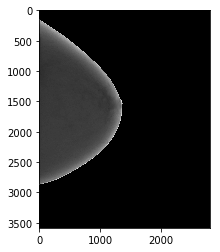

In [31]:
plt.imshow(a, cmap='gray')
#plt.hist(a.flatten())

In [5]:
# [STAR] For generating the projections

@jit(nopython=True, parallel=True)
def my_divide(x, y):
    return np.divide(x, y)

@jit(nopython=True, parallel=True)
def my_add(x, y):
    return np.add(x, y)

@jit(nopython=True, parallel=True)
def my_mul(x, y):
    return np.multiply(x, y)




#testvol = ndimage.zoom(testvol, 0.25, order=1)
#testvol = np.zeros([320, 448, 800], dtype='uint8')

scaling_factor = 1

SOD       = 65/0.025
ODD       = 4.5/0.025
detWidth  = 0.0085/0.025 #/(0.0255/scaling_factor)   # size of each detector pixel
detHeight = detWidth        # size of each detector pixel
detRows   = 3584
detCols   = 1600


num_angles = 25

#estimate = np.fromfile("/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/DBT_data/ClinicalExample/CE-05_R/ce.800x448x320.05-le.raw", dtype='float32')
#estimate = np.reshape(estimate, [320, 448, 800])


a       = sio.loadmat("/media/pranjal/cewitdata2/DBT-PROJ-DENOISE/attenuation_values_cropped/LE/1.mat")["head"]
testvol = np.rollaxis(a, 2, 0)
testvol = np.moveaxis(testvol, [0, 1, 2], [0, 2, 1])
testvol = testvol/65.0


vol_geom = astra.create_vol_geom(int(testvol.shape[1]), int(testvol.shape[2]), int(testvol.shape[0]))
proj_arr = np.zeros((num_angles, detCols, detRows), dtype='float16')
testones = np.ones([int(testvol.shape[0]), int(testvol.shape[1]), int(testvol.shape[2])],  dtype='uint8')
estimate = np.zeros([int(testvol.shape[0]), int(testvol.shape[1]), int(testvol.shape[2])], dtype='float16')

print('Starting Recon')


#proj_arr = np.array(proj_arr).astype('float16')
#proj_arr = np.rollaxis(proj_arr, 1, 0)
#proj_arr = proj_arr.flatten()


# All Flags
recon_type       = 0
use_old_calci    = 0 # Use already generated calcifications
save_projections = 1 # Save the projections
insert_noise     = 1


triple_dose  = True
quarter_dose = False
normal_dose  = False

# SIRT iteration LOOP
if recon_type == 0:
    niter      = 10
    start_time = time.time()
    
    for index in range(68, 69):
        print("Phantom ", index)
        a       = sio.loadmat("/media/pranjal/cewitdata2/DBT-PROJ-DENOISE/attenuation_values_cropped/LE/"+str(index)+".mat")["head"]
        testvol = np.rollaxis(a, 2, 0)
        testvol = np.moveaxis(testvol, [0, 1, 2], [0, 2, 1])
        volume_mask = testvol > 0
        
        testvol = np.multiply(volume_mask, testvol)
        testvol = testvol/65.0
        
        ang = []
        for i in range(num_angles):
            ang.append(1.9)
        start_angle = -25#+np.random.randint(0, 3)
        theta       = []
        for i in range(num_angles):
            theta.append(start_angle*np.pi/180.0)
            start_angle = start_angle+ang[i]
        
        vectors = np.zeros((len(theta), 12))
        
        # For reconstructing real data
        vectors[:, 0:3]  = np.transpose(np.array([np.sin(theta), np.zeros(len(theta)), np.cos(theta)])) * SOD        # S source to object
        vectors[:,3:6]   = np.transpose(np.array([np.zeros(len(theta)), np.zeros(len(theta)),  -np.ones(len(theta))*ODD]))             # D object to detector
        vectors[:,6:9]   = np.transpose(np.array([np.ones(len(theta))*detWidth, np.zeros(len(theta)), np.zeros(len(theta))]))         # U
        vectors[:,9:12]  = np.transpose(np.array([np.zeros(len(theta)), np.ones(len(theta))*detWidth, np.zeros(len(theta))]))        # V

        # Creating the projection matrix
        proj_geom        = astra.create_proj_geom('cone_vec', detCols, detRows, vectors)
        proj_id          = astra.create_projector('cuda3d',   proj_geom, vol_geom)
        W                = astra.OpTomo(proj_id)
        
        proj_arr         = W*testvol
        
        temp_proj = np.reshape(proj_arr, [detCols, num_angles, detRows])
        temp_proj = np.rollaxis(temp_proj, 0, 2)
        
        if triple_dose:
            I0        = 6000
            proj      = I0*np.exp(-temp_proj)
            proj_noi  = np.random.poisson(proj)
            proj_noi[proj_noi == 0] = 1
            
            g_noi                   = np.log(I0) - np.log(proj_noi) # convert back to line integrals 
            g_noi[g_noi < 0]        = 0
            
            fid = open('/media/pranjal/cewitdata1/DBT-PROJ-DENOISE/DOUBLE/'+str(temp_proj.shape[2])+'x'+str(temp_proj.shape[1])+'x'+str(temp_proj.shape[0])+'.'+str(index)+'.raw', 'w')
            np.array(proj_noi).astype('float32').tofile(fid)
            #np.array(g_noi).astype('float32').tofile(fid)
        
        if normal_dose:
            I0        = 2000
            proj      = I0*np.exp(-temp_proj)
            proj_noi  = np.random.poisson(proj)
            proj_noi[proj_noi == 0] = 1
            
            g_noi                   = np.log(I0) - np.log(proj_noi) # convert back to line integrals 
            g_noi[g_noi < 0]        = 0
            
            fid = open('/media/pranjal/cewitdata1/DBT-PROJ-DENOISE/NORMAL/'+str(temp_proj.shape[2])+'x'+str(temp_proj.shape[1])+'x'+str(temp_proj.shape[0])+'.'+str(index)+'.raw', 'w')
            np.array(proj_noi).astype('float32').tofile(fid)
            #np.array(g_noi).astype('float32').tofile(fid)
        
        if(quarter_dose):
            I0        = 500
            proj      = I0*np.exp(-temp_proj)
            proj_noi  = np.random.poisson(proj)
            proj_noi[proj_noi == 0] = 1
            
            g_noi                   = np.log(I0) - np.log(proj_noi) # convert back to line integrals 
            g_noi[g_noi < 0]        = 0
            
            fid = open('/media/pranjal/cewitdata1/DBT-PROJ-DENOISE/QUARTER/'+str(temp_proj.shape[2])+'x'+str(temp_proj.shape[1])+'x'+str(temp_proj.shape[0])+'.'+str(index)+'.raw', 'w')
            #np.array(proj_noi).astype('float32').tofile(fid)
            np.array(g_noi).astype('float32').tofile(fid)
        
            #g_noi                   = np.log(I0) - np.log(proj_noi) # convert back to line integrals 
            #g_noi[g_noi < 0]        = 0
            #proj_arr = proj_noi#g_noi
        
#         temp_proj  = np.reshape(proj_arr, [detCols, num_angles, detRows])
#         temp_proj1 = temp_proj[:, 15:-15, :]
        
#         # Saving the Projections
#         if save_projections:
#             fid = open('/media/pranjal/cewitdata2/DBT-PROJ-DENOISE/QUARTER/'+str(temp_proj.shape[2])+'x'+str(temp_proj.shape[0])+'x'+str(temp_proj.shape[1])+'.'+str(index)+'.raw', 'w')
#             temp_proj  = np.rollaxis(temp_proj, 0, 2)
#             np.array(temp_proj).astype('float32').tofile(fid)
        

Starting Recon
Phantom  68


In [1]:
import numpy as np
index = 68
all_proj = np.fromfile("/media/pranjal/cewitdata1/DBT-PROJ-DENOISE/NORMAL/3200x1600x25."+str(index)+".raw", dtype='float32')
all_proj = np.reshape(all_proj, [25, 1600, 3200])
                      
print(all_proj.shape)

(25, 1600, 3200)


In [6]:
a       = sio.loadmat("/media/pranjal/cewitdata2/DBT-PROJ-DENOISE/attenuation_values_cropped/LE/"+str(index)+".mat")["head"]
print(a.shape)        

(800, 448, 320)


In [82]:
# [STAR] Code to read the data

a = np.fromfile('/media/pranjal/cewitdata1/pranjal/CT-RECON-DATA/MC_CE27_slice32_atzz666_dense_uppaddle_pc_209923395_crop_1073x2748x816.raw', dtype='uint8')
a = np.reshape(a, [816, 2748, 1073])

print(a.shape)

temp = a[666]

(816, 2748, 1073)


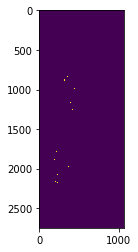

In [83]:
temp[temp != 250] = 0
plt.imshow(temp)

(750, 350)


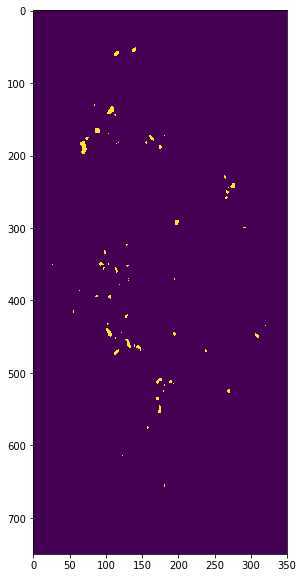

In [84]:
plt.figure(figsize=(20,10))
temp1 = temp[700:1450, 250:600]
print(temp1.shape)
plt.imshow(temp1)

In [77]:
np.save('calcification_cluster.npy', temp1)

(1140, 2415, 1740)


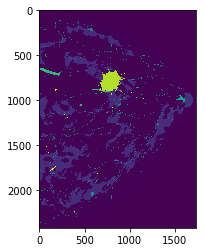

In [3]:
a = np.fromfile('/media/pranjal/cewitdata1/pranjal/CT-RECON-DATA/pcl_22183101_crop.raw', dtype='uint8')
a = np.reshape(a, [1140, 2415, 1740])
#  1740   2415   1140

print(a.shape)

#temp = a[666]
plt.imshow(a[500])

In [4]:
temp1 = np.load('calcification_cluster.npy')
print(temp1.shape)

(750, 350)


In [89]:
a1    = a[500, 1500:1500+temp1.shape[0], 150:150+temp1.shape[1]]
temp1[temp1 != 250] = a1[temp1 != 250]

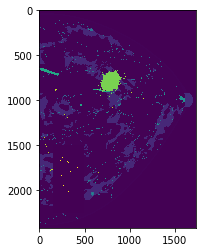

In [6]:
#a[499, 1500:1500+temp1.shape[0], 150:150+temp1.shape[1]] =  temp1
#a[500, 1500:1500+temp1.shape[0], 150:150+temp1.shape[1]] =  temp1
#a[501, 1500:1500+temp1.shape[0], 150:150+temp1.shape[1]] =  temp1

plt.imshow(a[501])

In [7]:
a.tofile('/media/pranjal/cewitdata1/pranjal/CT-RECON-DATA/pcl_22183101_crop_calci.raw')

(1771,) (1771,)
(58, 1200, 3000) (58, 1200, 3000) (58, 1200, 3000)


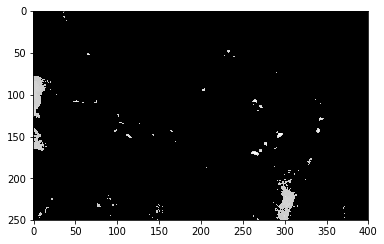

In [411]:
# [STAR] For creating the dataset to train the potential function

e = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3000x1200x58.4_4_0.0005_-0.5_1_anistropic_three_1.raw', dtype='float32')
e = np.reshape(e, [58, 1200, 3000])

a = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3000x1200x58.0_0_0.0005_0_1_anistropic_normal_1.raw', dtype='float32')
a = np.reshape(a, [58, 1200, 3000])

b = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3000x1200x58.0_1_0.0005_0_1_anistropic_normal_1.raw', dtype='float32')
b = np.reshape(b, [58, 1200, 3000])

c = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3000x1200x58.0_1_0.0005_0_1_anistropic_three_1.raw', dtype='float32')
c = np.reshape(c, [58, 1200, 3000])

d = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3000x1200x58.0_0_0.0005_0_1_anistropic_three_1.raw', dtype='float32')
d = np.reshape(d, [58, 1200, 3000])

temp1 = a[:, 900:1150, 950:1350]
temp2 = b[:, 900:1150, 950:1350]

C2    = c[:, 900:1150, 950:1350]
D2    = d[:, 900:1150, 950:1350]

# C2 = A1 + ((A2-A1)+B1)

Y_array = D2#C2 - temp2 
X_array = temp1


# For getting the locations of the training data points

temp  = e[27, 900:1150, 950:1350]
temp[temp < 0.047] = 0
plt.imshow(temp, cmap='gray')

non_zero_index = np.nonzero(temp)

print(non_zero_index[0].shape, non_zero_index[1].shape)
print(a.shape, b.shape, e.shape)

In [412]:
#p1 = np.take(temp1, )

X = []
Y = []
voxels = 5

for i in range(non_zero_index[0].shape[0]):
    tx = X_array[27-2:27+3, non_zero_index[0][i]-2:non_zero_index[0][i]+3, non_zero_index[1][i]-2:non_zero_index[1][i]+3]
    #tx = temp1[27-1:27+2, non_zero_index[0][i]-1:non_zero_index[0][i]+2, non_zero_index[1][i]-1:non_zero_index[1][i]+2]
    #ty = temp3[27-1:27+2, non_zero_index[0][i]-1:non_zero_index[0][i]+2, non_zero_index[1][i]-1:non_zero_index[1][i]+2]
    ty = Y_array[27, non_zero_index[0][i], non_zero_index[1][i]]
    
    #print(tx.shape, ty.shape)
    if tx.shape[0] == voxels and tx.shape[1] == voxels and tx.shape[2] == voxels:
        X.append(tx)
        Y.append(ty)

print(len(X), len(Y), non_zero_index[0].shape[0])

X =  np.array(X)
X =  np.reshape(X, [X.shape[0], voxels*voxels*voxels])
Y =  np.array(Y)

print(X.shape, Y.shape)

1609 1609 1771
(1609, 125) (1609,)


In [413]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

#X, y = make_regression(n_samples=200, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


#X_train = X_train*100
#X_test  = X_test*100
#y_train = y_train*100
#y_test  = y_test*100

regr   = MLPRegressor(activation='tanh', 
                      random_state=0, 
                      solver='adam',
                      learning_rate_init=0.0001,
                      #learning_rate='adaptive', 
                      hidden_layer_sizes=(125,25),
                      #verbose=True,
                      tol=0.001,
                      alpha=0.0001, max_iter=500).fit(X_train, y_train)

result = regr.predict(X_test)

from sklearn.metrics import r2_score

print('Score is ', r2_score(result, y_test))
#print(result.shape, X_test.shape, y_test.shape)

error = result-y_test
error = np.square(error)
print('Error is ', np.mean(error)*10000)

(1206, 125) (403, 125) (1206,) (403,)
Score is  0.9176320102707205
Error is  0.015204905968639758


(array([ 10.,  71.,  43.,  30.,  16.,  12.,  14.,  44., 101.,  62.]),
 array([0.02508045, 0.02646247, 0.02784449, 0.0292265 , 0.03060852,
        0.03199054, 0.03337256, 0.03475458, 0.03613659, 0.03751861,
        0.03890063]),
 <a list of 10 Patch objects>)

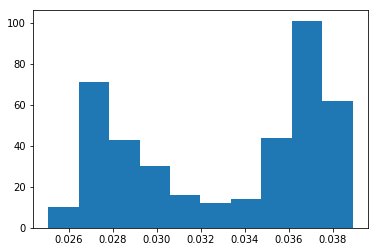

In [414]:
plt.hist(result)

(array([ 3., 77., 42., 30.,  7., 22.,  2., 34., 93., 93.]),
 array([0.0273556 , 0.0284527 , 0.02954979, 0.03064689, 0.03174398,
        0.03284108, 0.03393818, 0.03503527, 0.03613237, 0.03722947,
        0.03832656], dtype=float32),
 <a list of 10 Patch objects>)

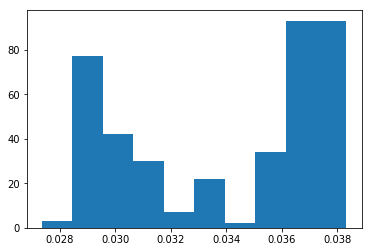

In [415]:
plt.hist(y_test)

In [333]:
#print(zip(result, y_test))
print(result[:10])
print(y_test[:10])
#print(regr)

[ 0.00095013 -0.00015663  0.00115547 -0.00011086  0.00073077 -0.00060271
  0.00088207 -0.00039391  0.00104068  0.0001432 ]
[-2.0232797e-04  2.3423508e-04  2.5516376e-05  4.1769445e-04
  3.2828748e-04 -9.5218420e-05  2.2611767e-04  4.5547634e-04
  7.5456873e-04  8.1414729e-04]


In [123]:
c = regr.coefs_

#print(len(c))

print(c[0].shape, c[1].shape)

print(c)

2
(27, 27) (27, 1)
[array([[-0.05867149,  0.14876499, -0.33249167, -0.148559  , -0.23728055,
        -0.26915091, -0.21144593, -0.10546348, -0.07144544,  0.0231397 ,
        -0.05051322,  0.1227671 , -0.19363711,  0.2601569 , -0.31201733,
         0.11621134, -0.05281139,  0.03541126, -0.23588233, -0.20313476,
         0.19671539,  0.30939685, -0.1247321 ,  0.12515522,  0.24602535,
         0.26523186, -0.27901123],
       [-0.30873703, -0.21723257,  0.24939834, -0.26740013, -0.05461485,
         0.30706058,  0.01931294,  0.1251678 , -0.1254191 ,  0.12158619,
         0.22555865, -0.31729017,  0.16931707,  0.33024982,  0.16740061,
        -0.14309876,  0.19453869, -0.26625982, -0.03174828,  0.26977804,
        -0.14018055, -0.14336708, -0.24610006, -0.32232463,  0.11526311,
        -0.18965857, -0.15894965],
       [-0.00909065, -0.29475312,  0.04805764, -0.23901428,  0.05741931,
         0.13507421, -0.26702397, -0.05964629,  0.12688795, -0.05962829,
        -0.29621509,  0.02406115, 

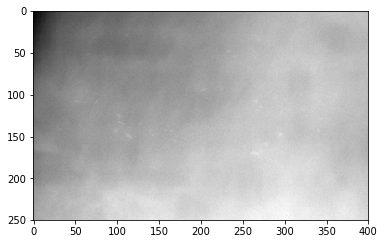

In [368]:
plt.imshow(b[27, 900:1150, 950:1350], cmap='gray')

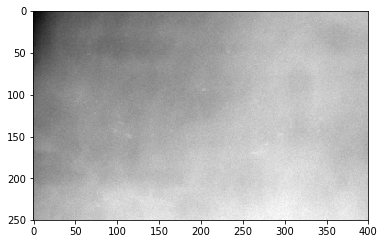

In [370]:
plt.imshow(a[27, 900:1150, 950:1350], cmap='gray')